In [1]:
# external libraries
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import AutoModelForCausalLM, AutoTokenizer

import tqdm.auto as tqdm
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import numpy as np

# custom libraries
from src.dataset_handling import TextClassificationDataset 
from src.utils import get_hidden_activations_multiple_hookpoints, activation_label_generator
from src.sparse_probes import ClassificationProbe

In [2]:
model_url = "EleutherAI/pythia-14m"
hookpoint_name = 'gpt_neox.layers.$.mlp.act'

model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_url)
batch_size = 32

num_hookpoints = model.config.num_hidden_layers
hookpoints = [hookpoint_name.replace('$', str(i)) for i in range(num_hookpoints)]
input_size = model.config.intermediate_size

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)
    
dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

In [3]:
class ProbeTrainer():
    def __init__(self, input_size, learning_rate, reg_lambda, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.hookpoint = hookpoint
        self.name = f'{self.hookpoint}.lambda{self.reg_lambda}'

        self.model = ClassificationProbe(in_dim=self.input_size, device=device).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.BCELoss()

        self.batches = 0

        self.losses = []

    def train_step(self, input_, labels):
        outputs = self.model(input_)
        loss = self.loss_fn(outputs, labels)
        pre_reg_loss = loss.item()
        loss += self.reg_lambda * sum(torch.norm(param, 2) for param in self.model.parameters())
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), pre_reg_loss))
        self.batches += 1
        return loss
    
    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, pre_reg_losses = zip(*self.losses) 
        ax.plot(losses, label='Loss')
        ax.plot(pre_reg_losses, label='Pre-regularization loss')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax.set_title(self.name)
        fig.legend()
        
        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [4]:

learning_rate=1e-3
reg_lambdas = np.logspace(np.log10(0.1), np.log10(30), 10)

probe_trainers = [
    ProbeTrainer(input_size, learning_rate, reg_lambda, hookpoint, device)
    for reg_lambda in reg_lambdas
        for hookpoint in hookpoints
] 

for activations, labels in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    for probe_trainer in probe_trainers:
        loss = probe_trainer.train_step(activations[probe_trainer.hookpoint], labels)
        print(f'{loss}\t', end='')
    print('')


  0%|          | 0/2070 [00:00<?, ?it/s]

0.7415620684623718	0.7257263660430908	0.741740345954895	0.7487351894378662	0.7291837334632874	0.6917600631713867	0.7921249270439148	0.8039970993995667	0.7942412495613098	0.7780205011367798	0.8406726121902466	0.7481485605239868	0.9279335737228394	0.9128463268280029	0.9178735017776489	0.9610267281532288	0.9525530338287354	0.9803822040557861	1.1226682662963867	1.0968444347381592	1.0737677812576294	1.0824191570281982	1.0218839645385742	1.0953415632247925	1.4201281070709229	1.4422051906585693	1.4683958292007446	1.51961350440979	1.4498323202133179	1.5451552867889404	2.2223143577575684	2.1672372817993164	2.1055822372436523	2.130462646484375	2.109572649002075	2.0273489952087402	3.3362247943878174	3.2632484436035156	3.3617758750915527	3.431962251663208	3.3910927772521973	3.3250155448913574	5.57958459854126	5.508100509643555	5.5226359367370605	5.901712894439697	5.5101399421691895	5.837917327880859	10.24670124053955	10.173401832580566	10.010621070861816	10.833150863647461	10.268010139465332	10.27

KeyboardInterrupt: 

C:\Users\Bruger\AppData\Local\Temp\ipykernel_15276\3421213004.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(12, 8))


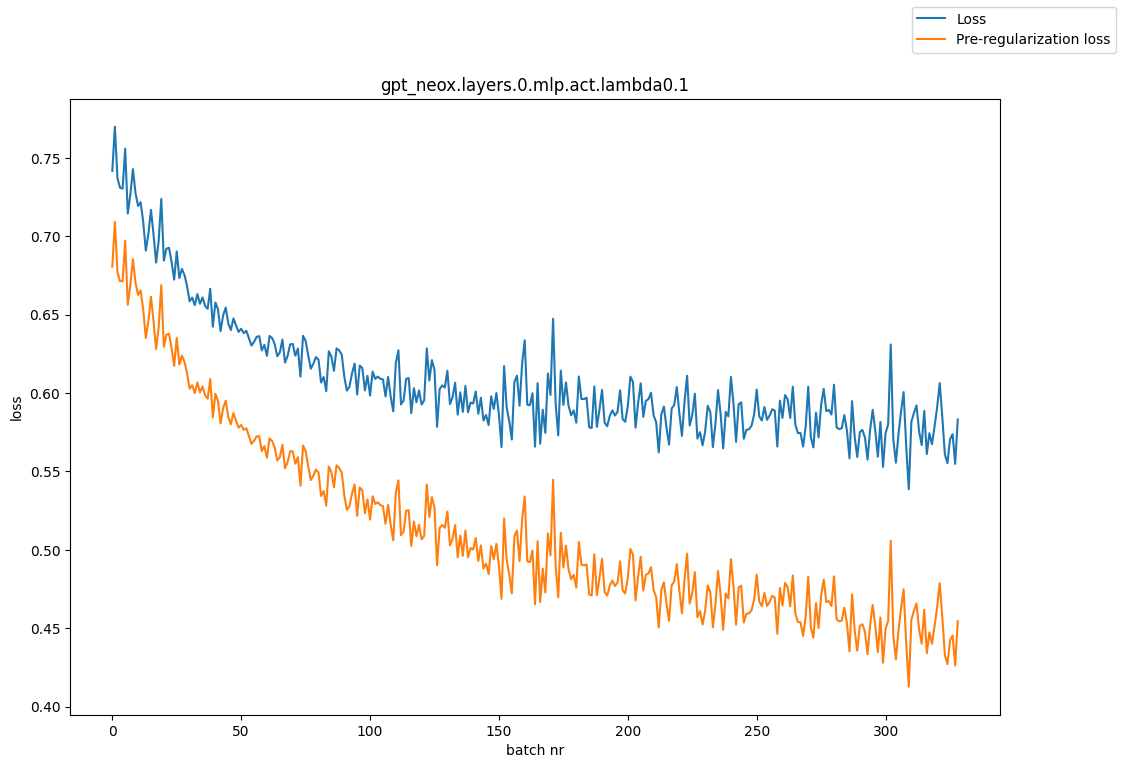

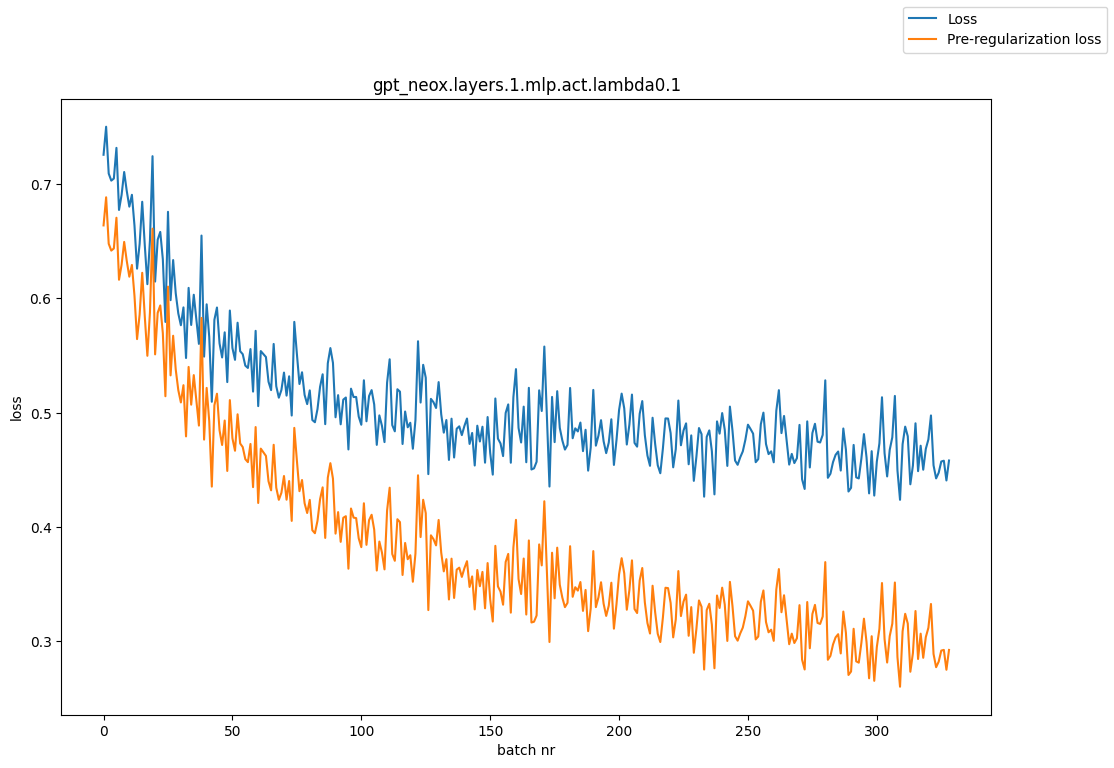

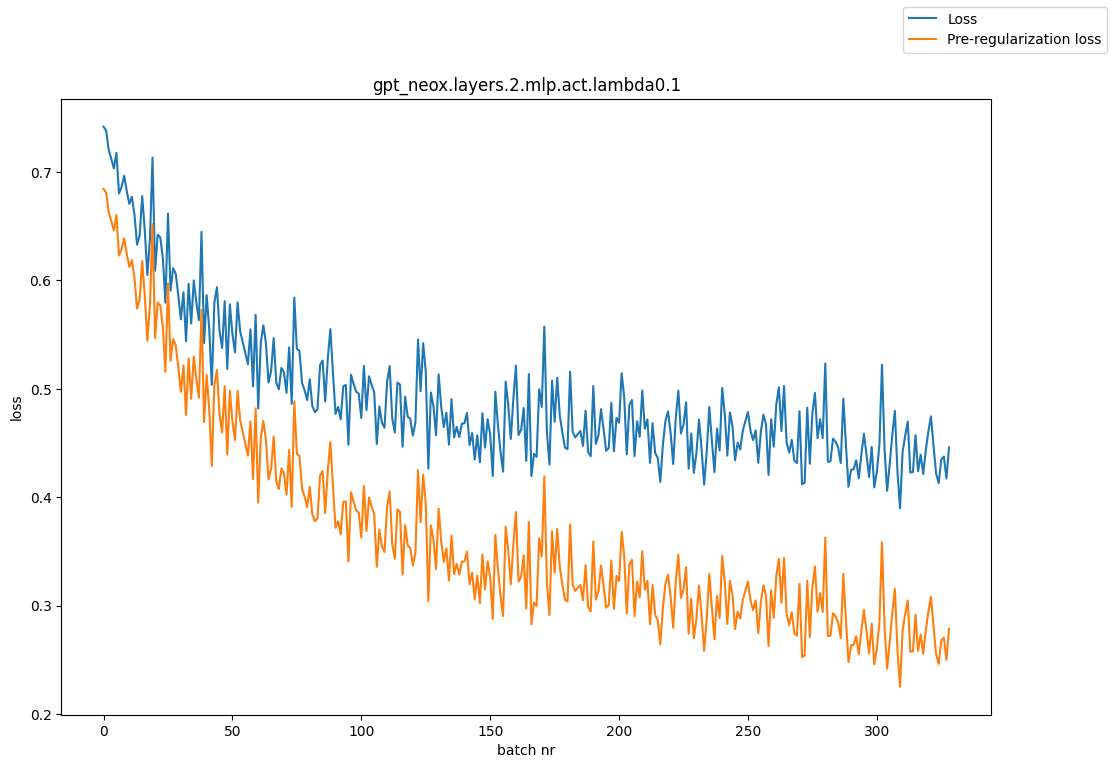

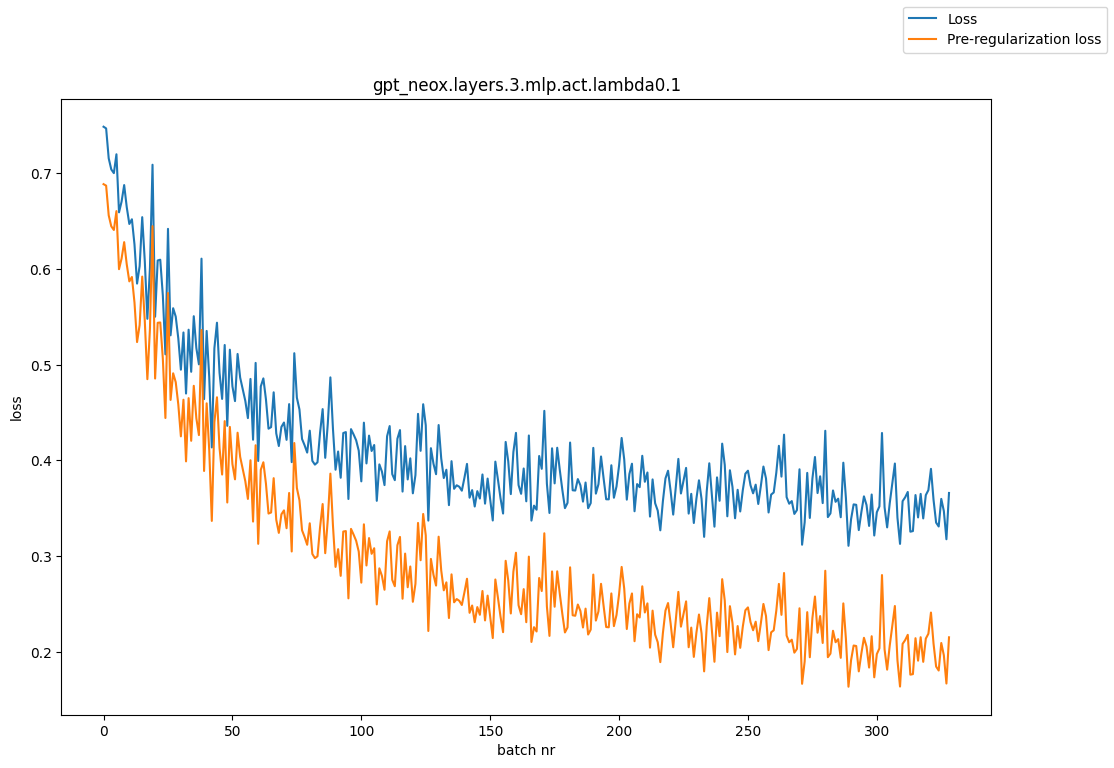

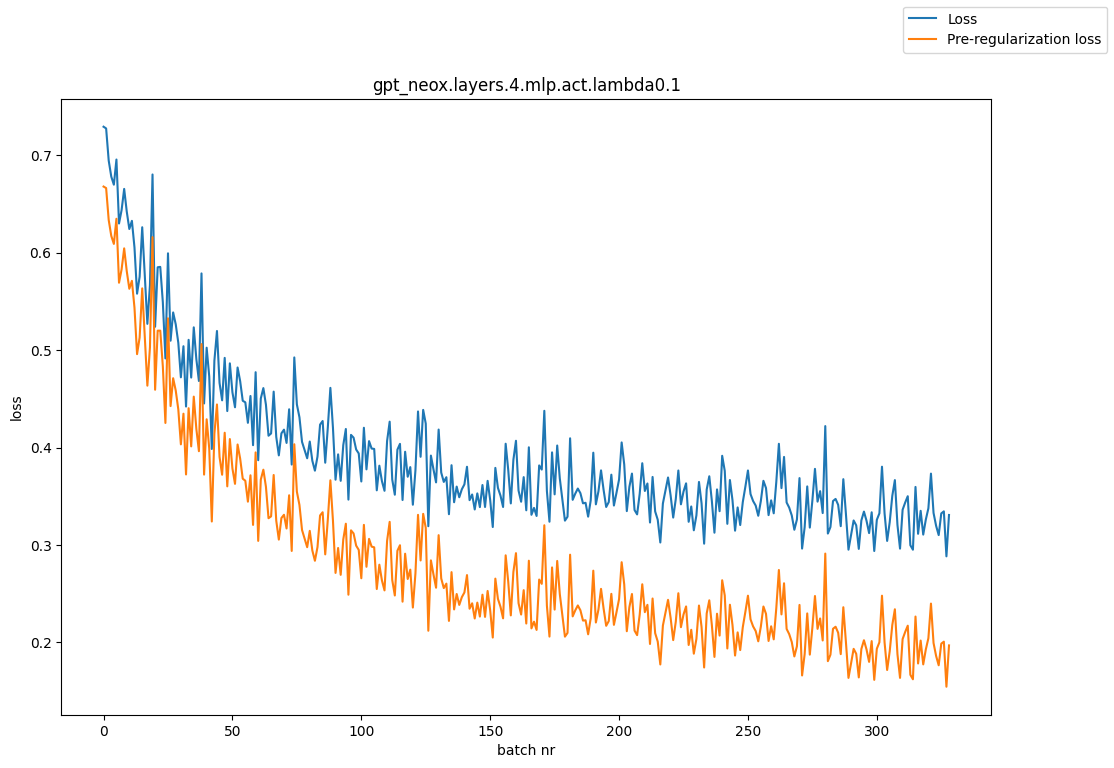

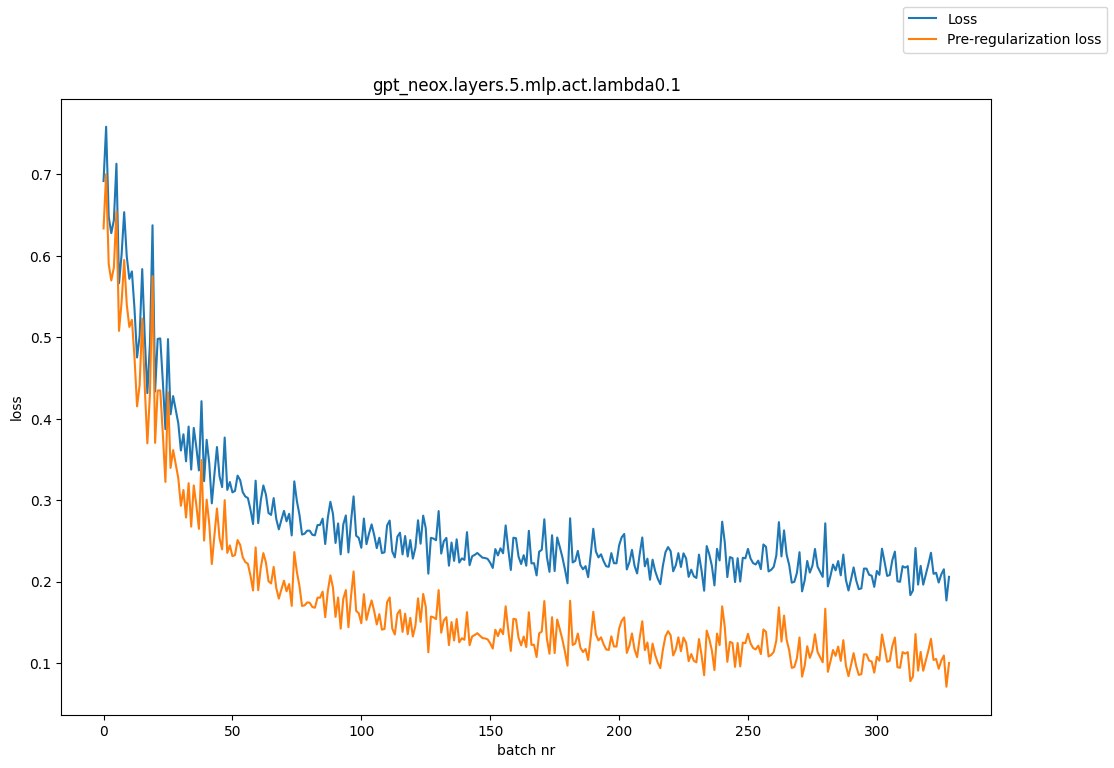

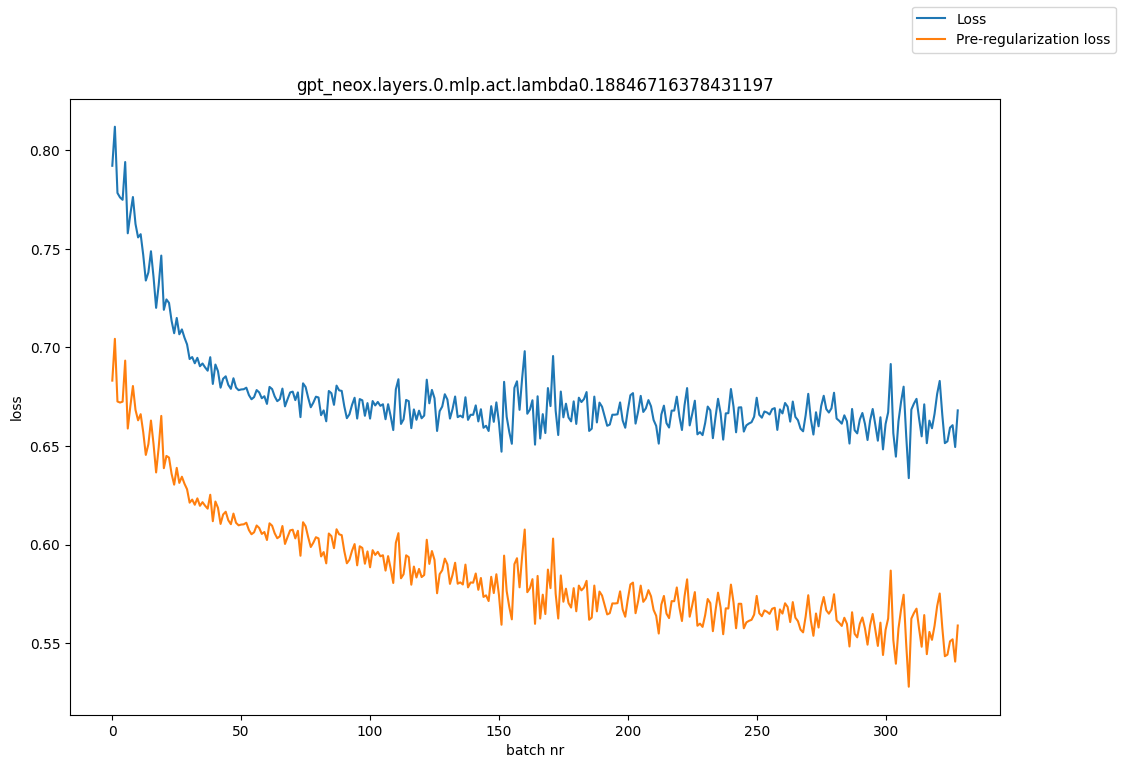

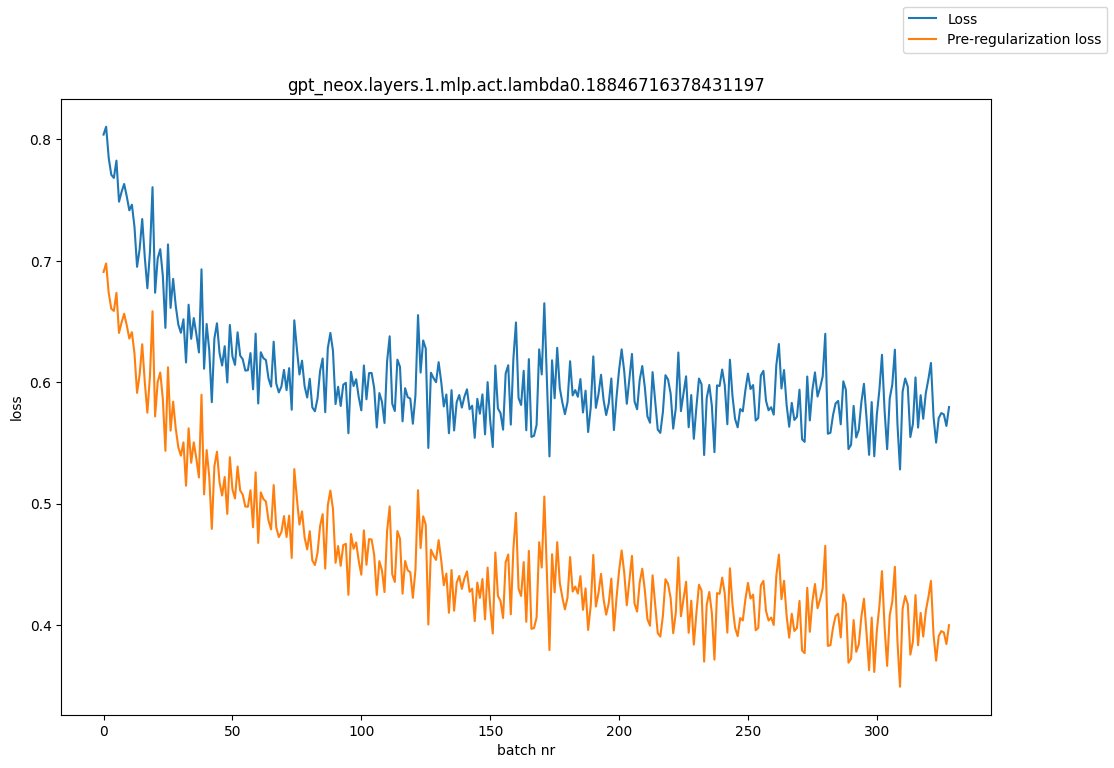

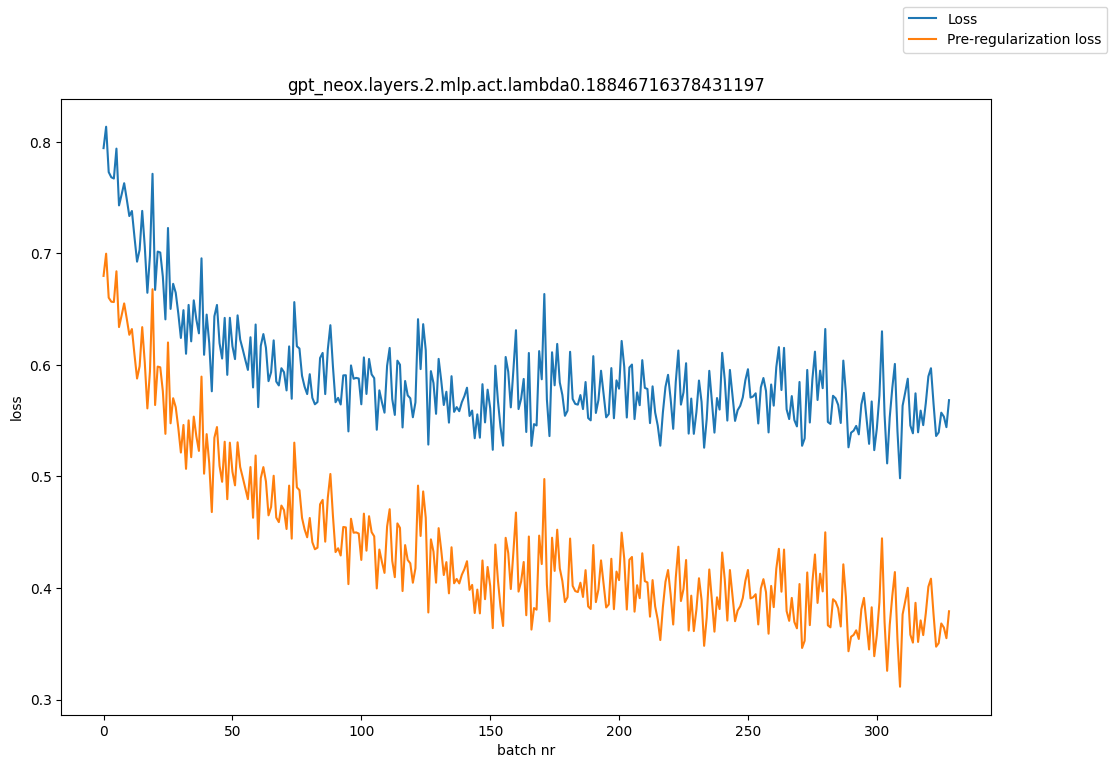

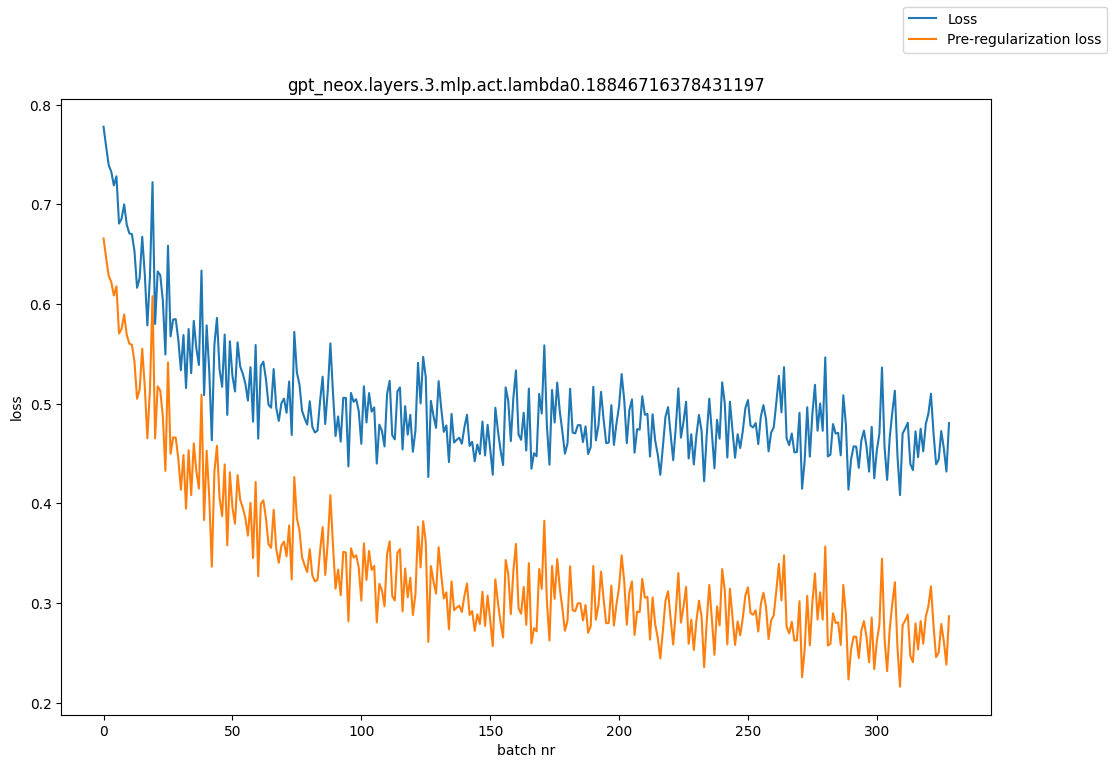

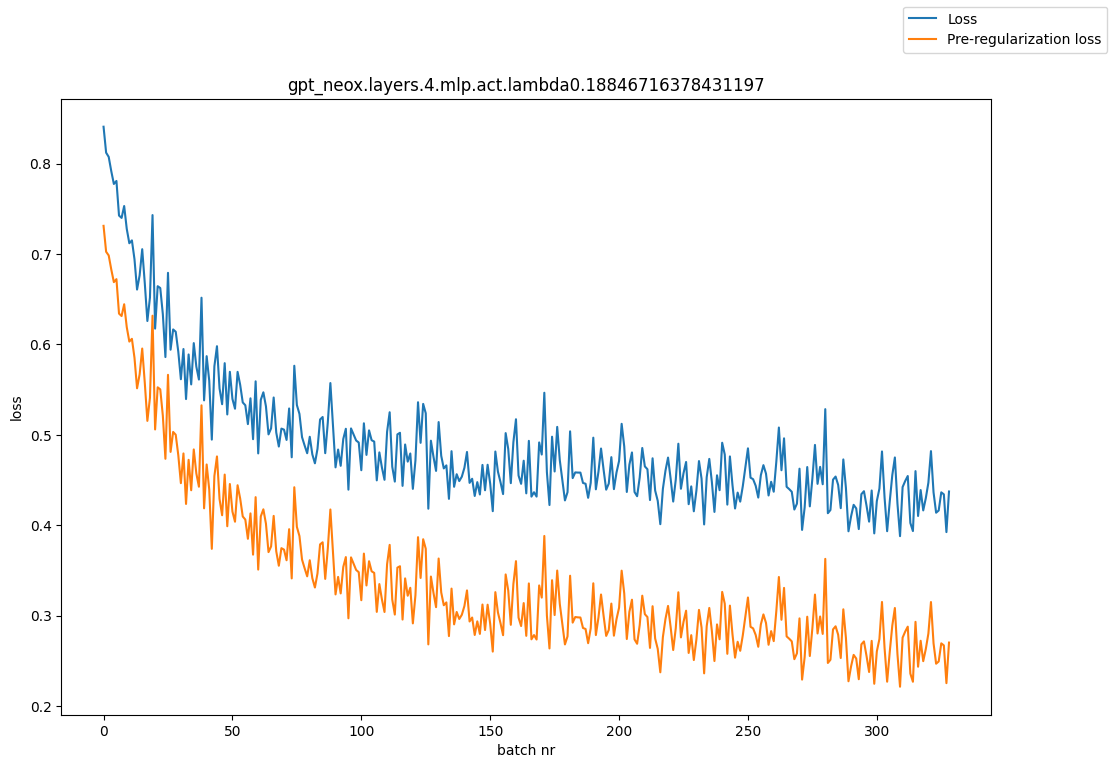

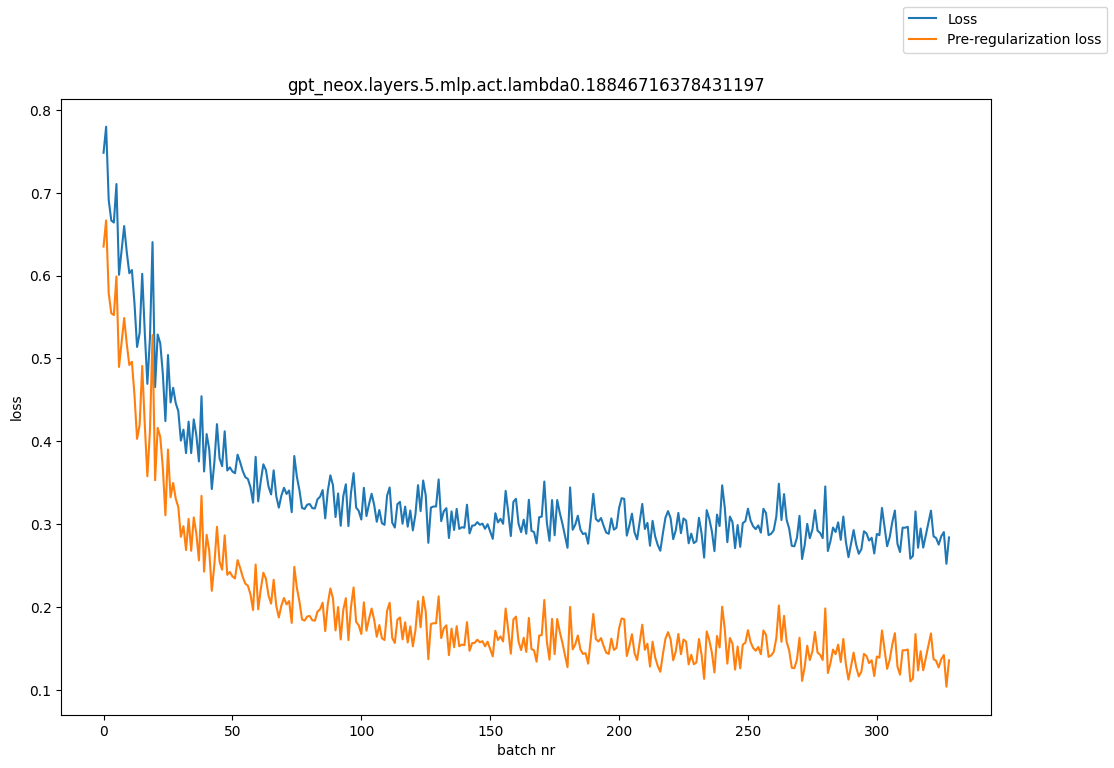

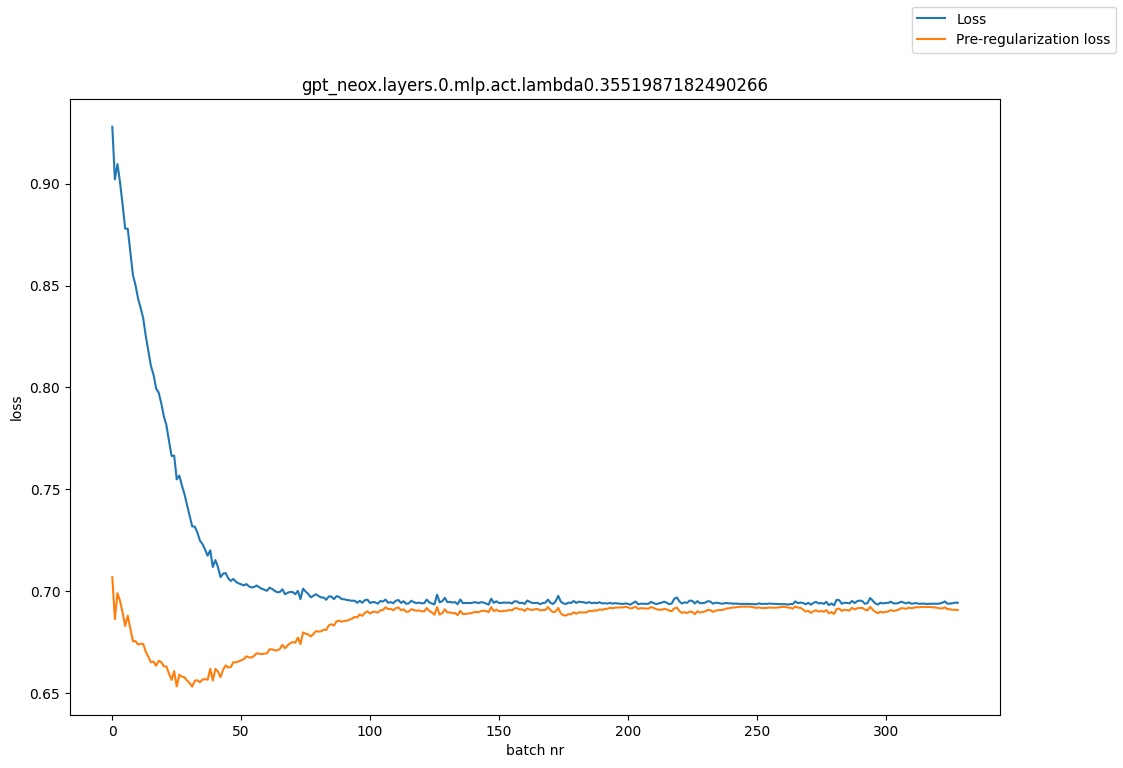

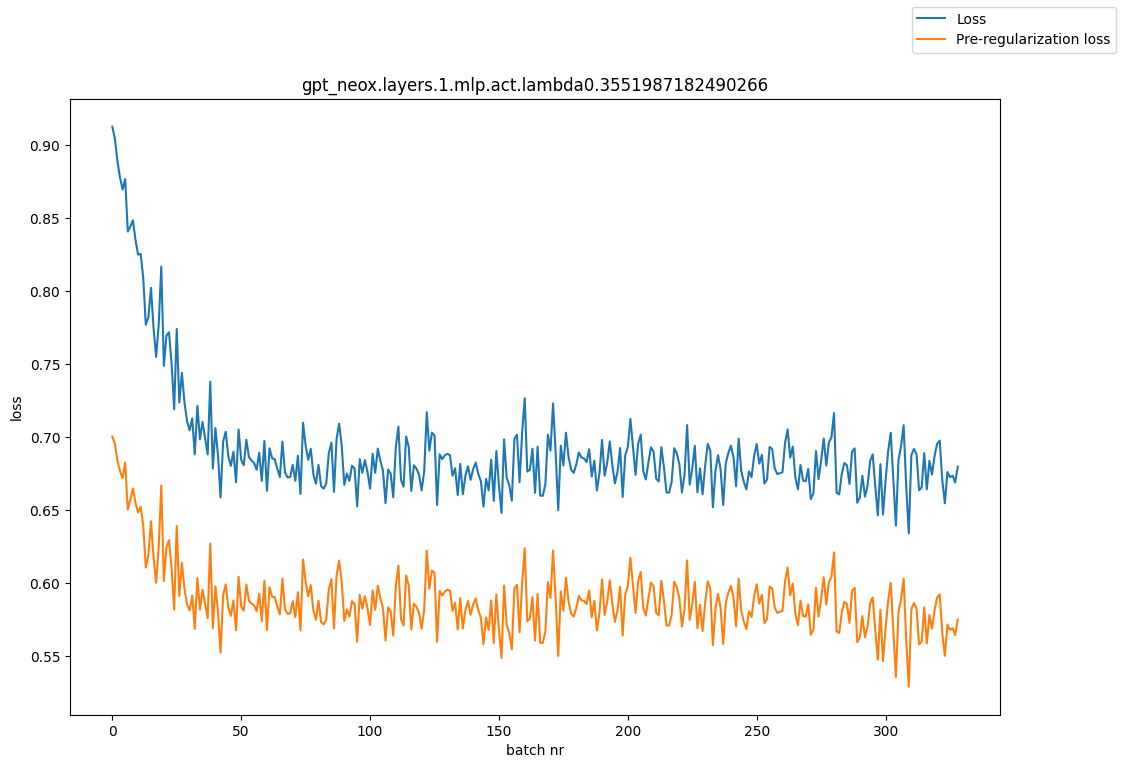

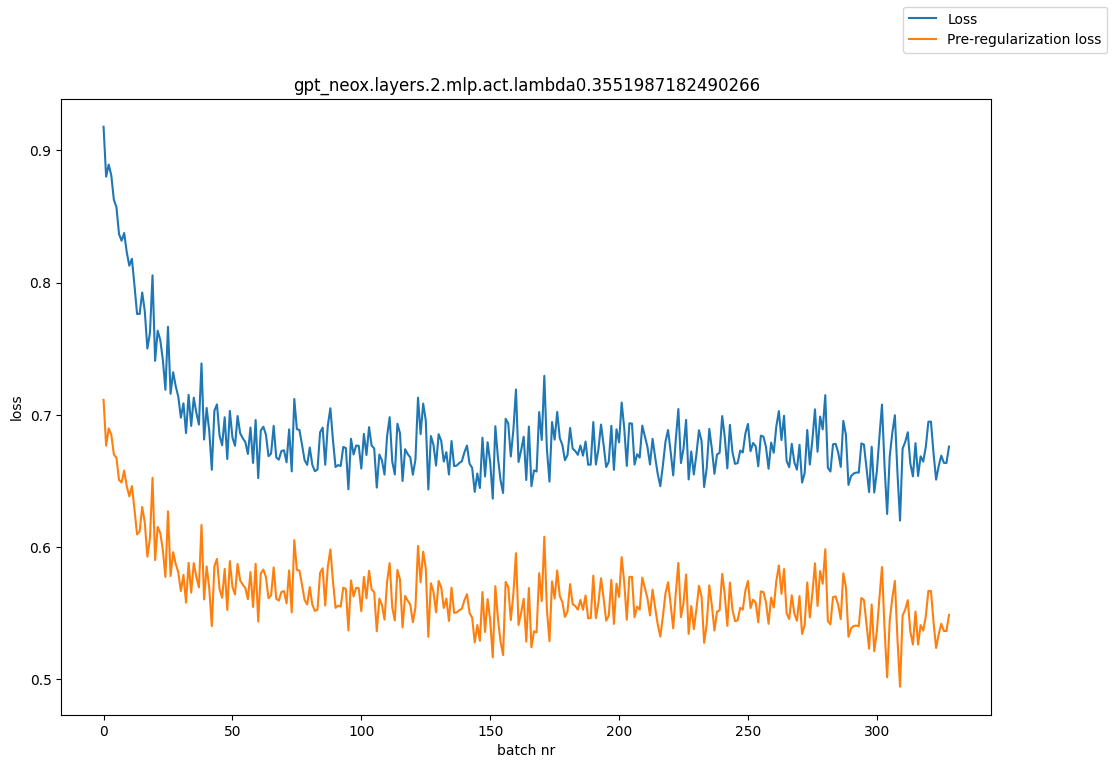

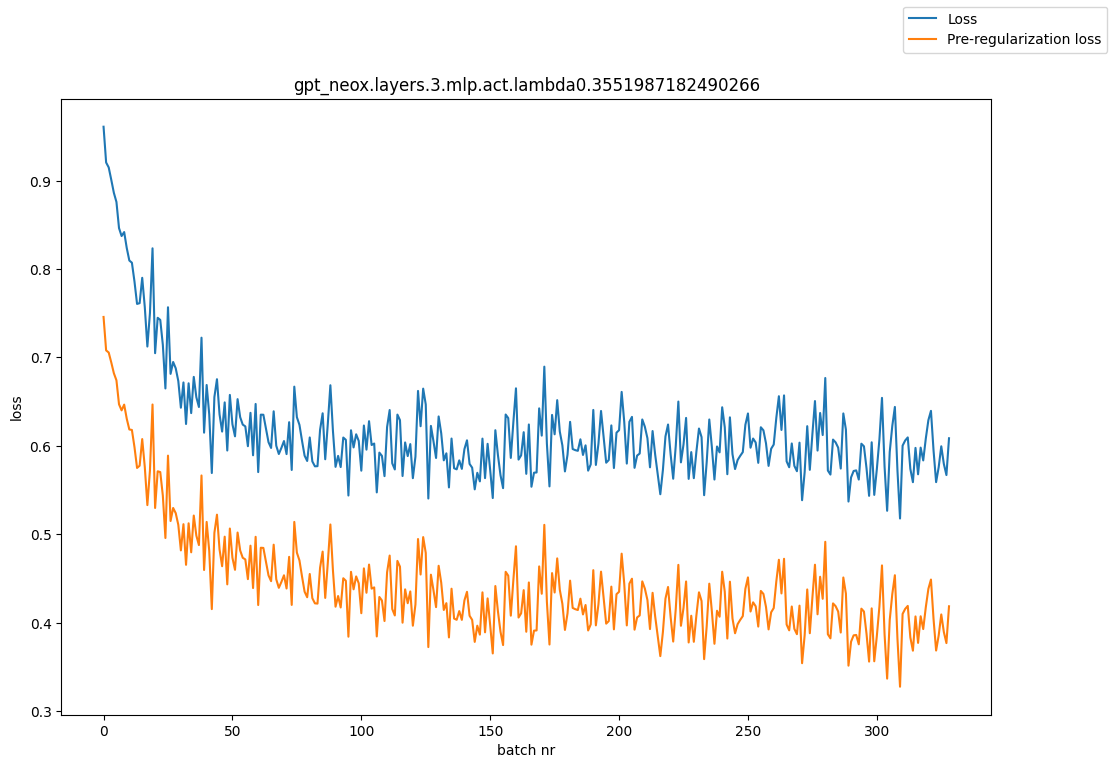

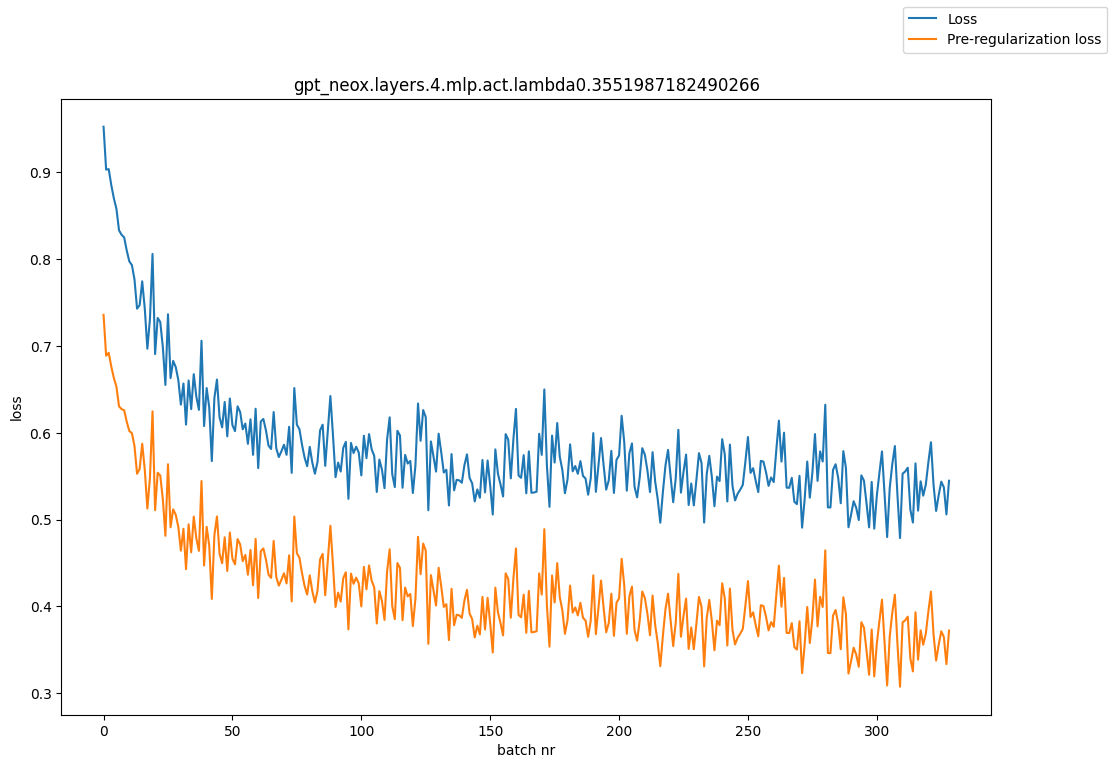

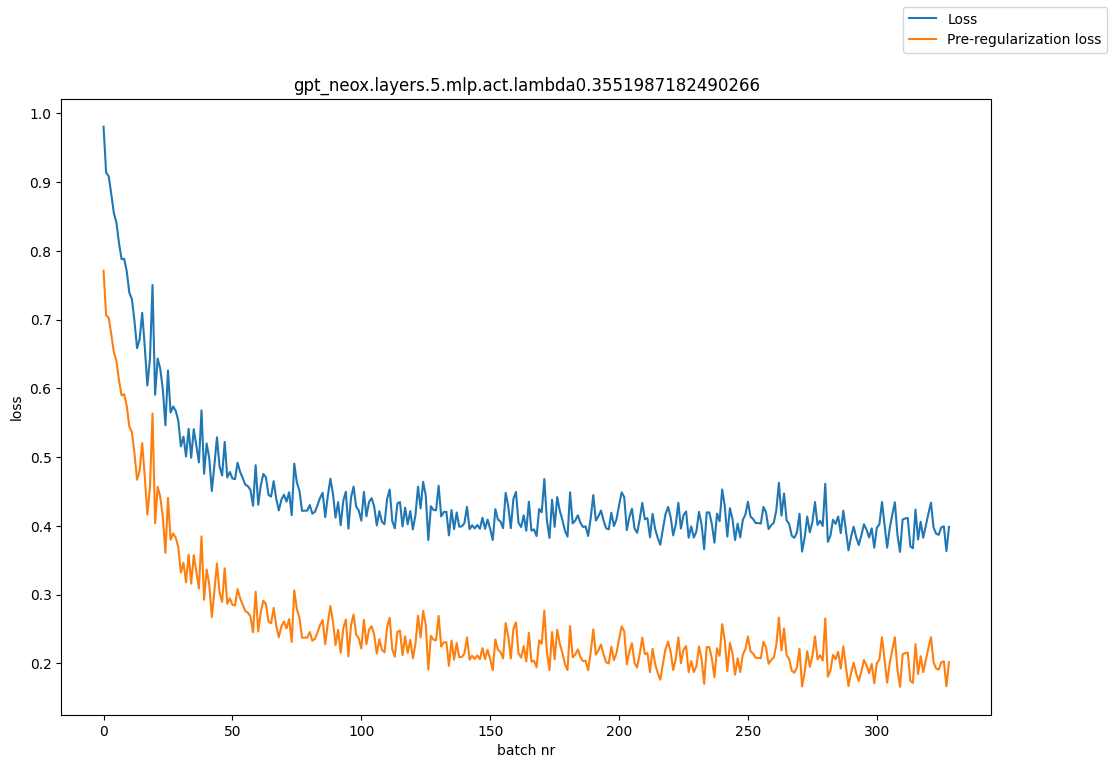

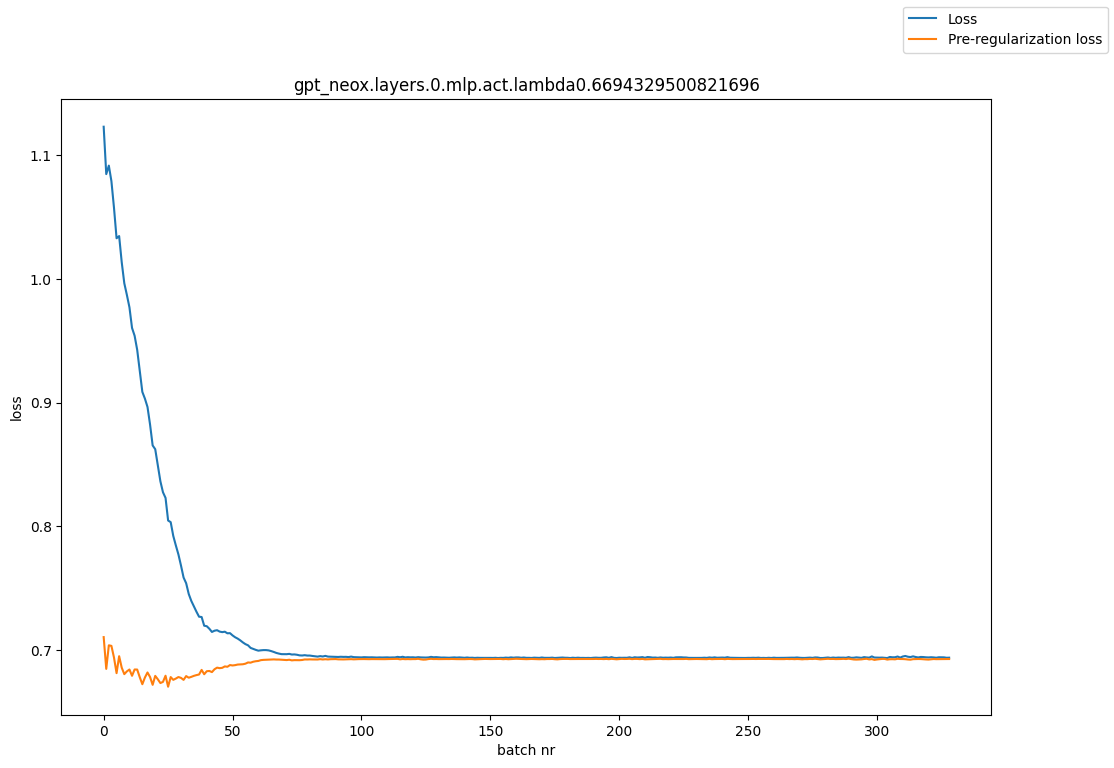

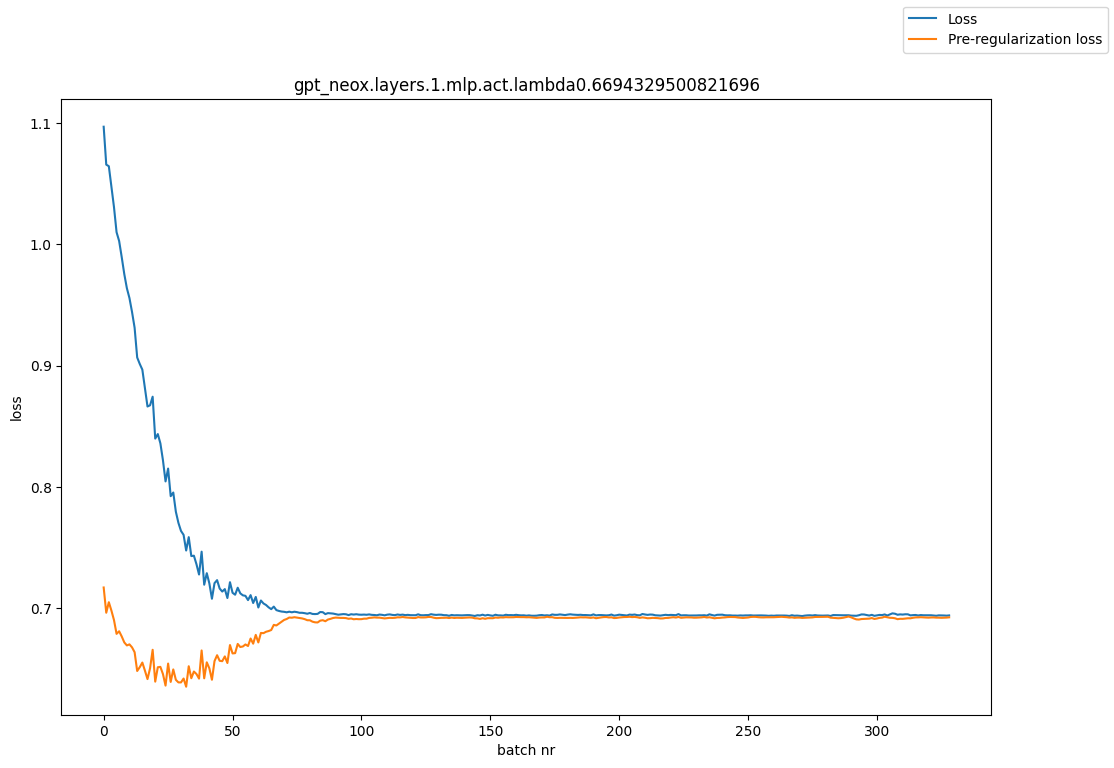

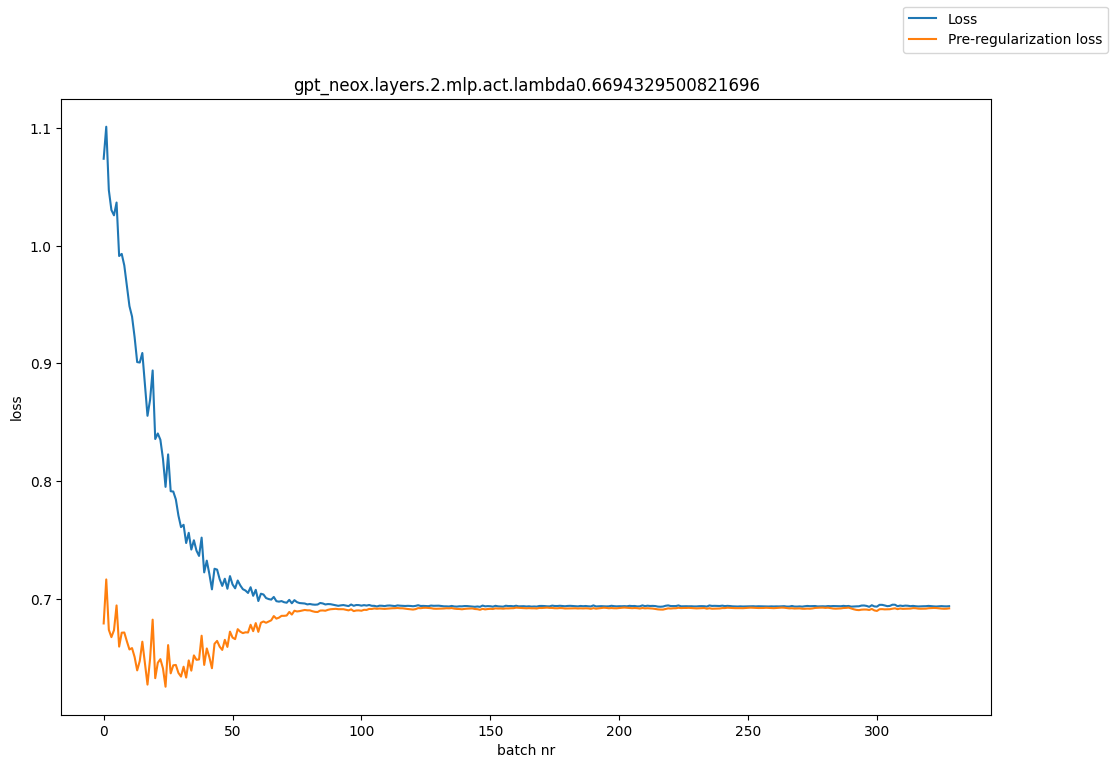

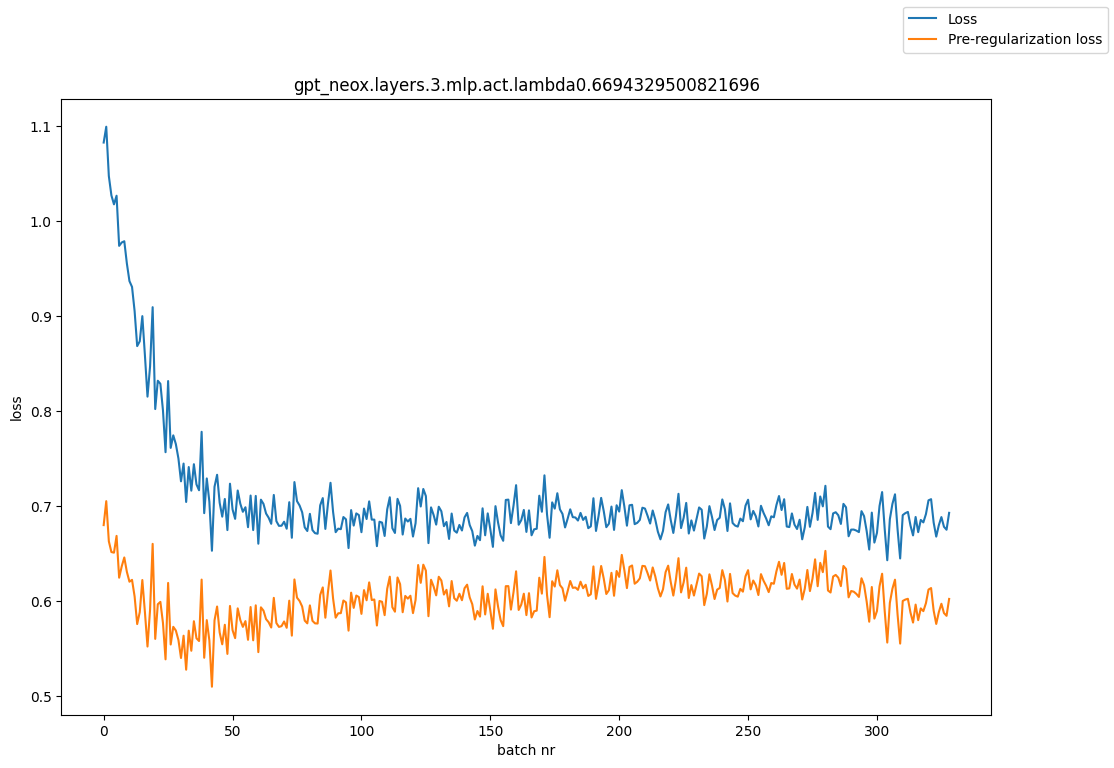

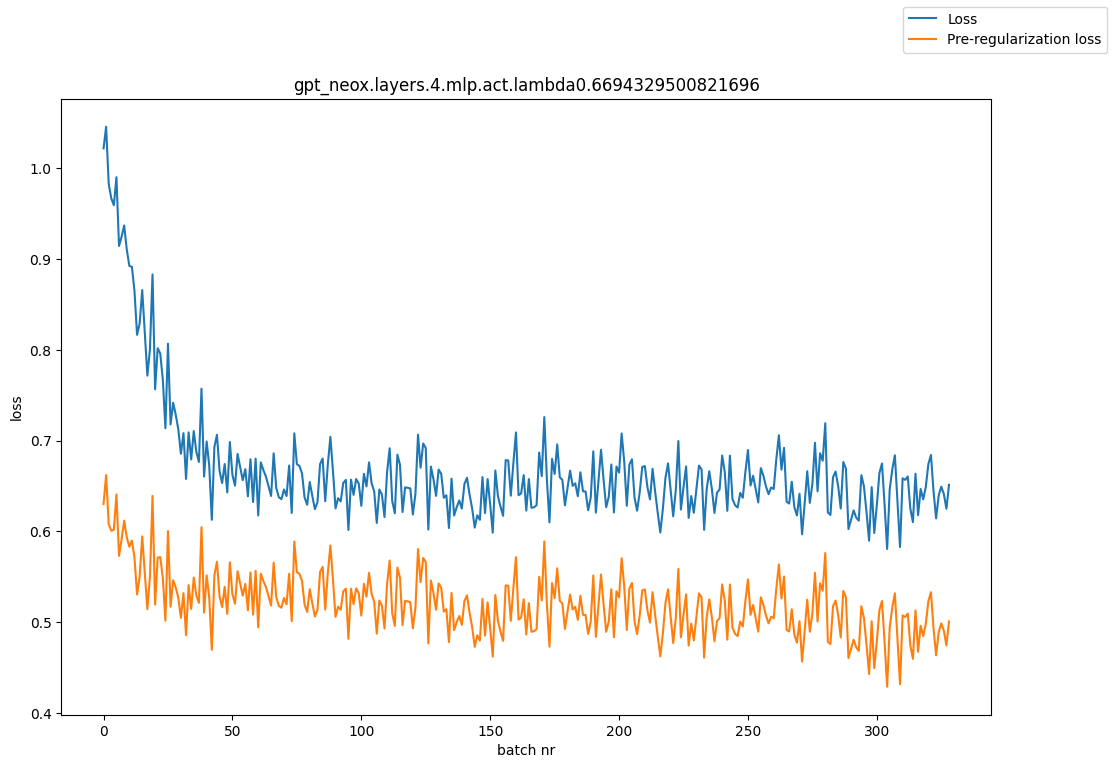

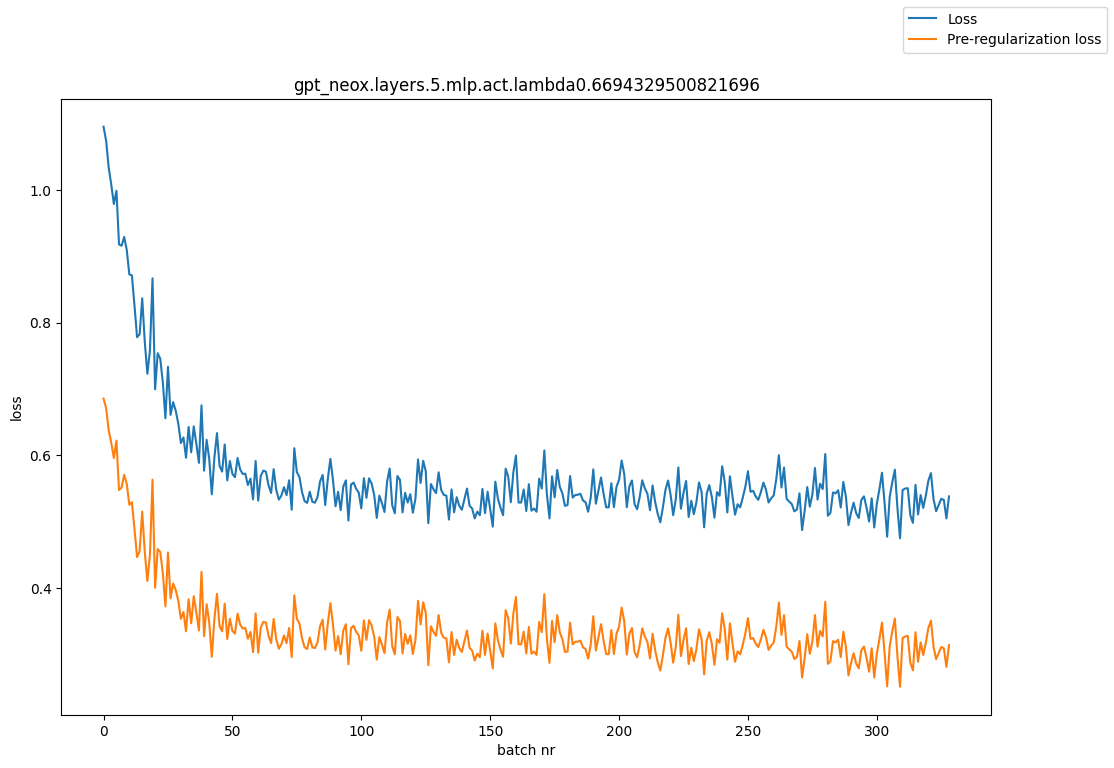

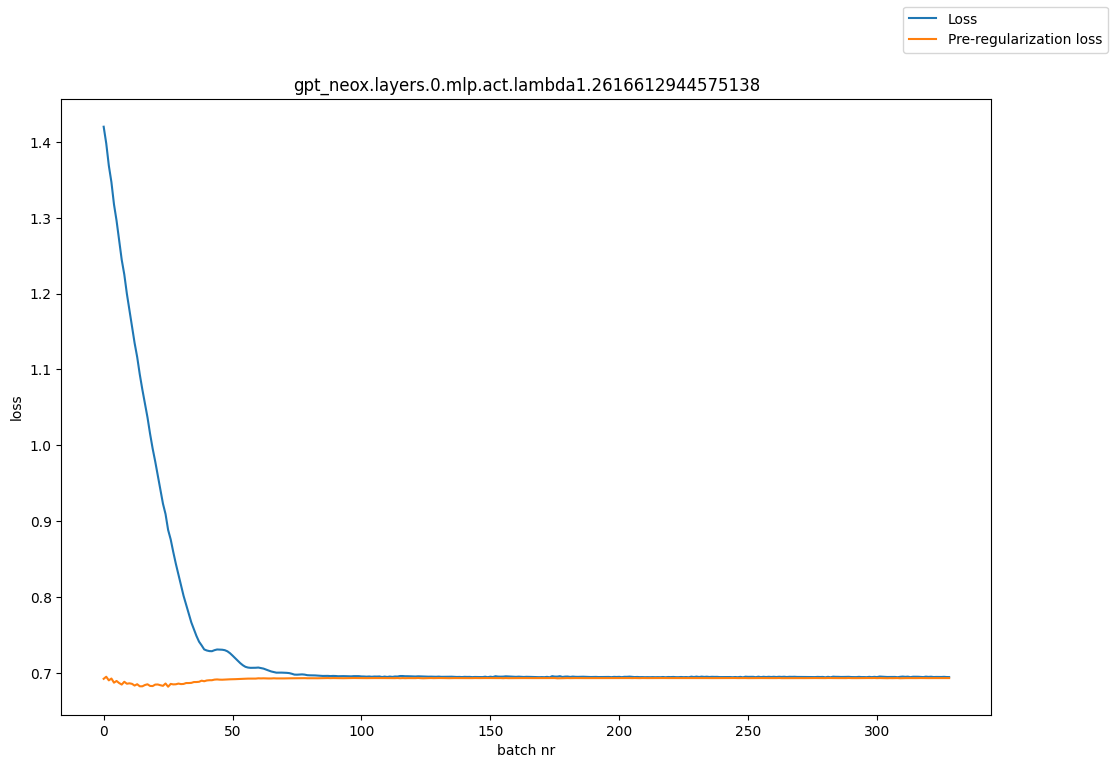

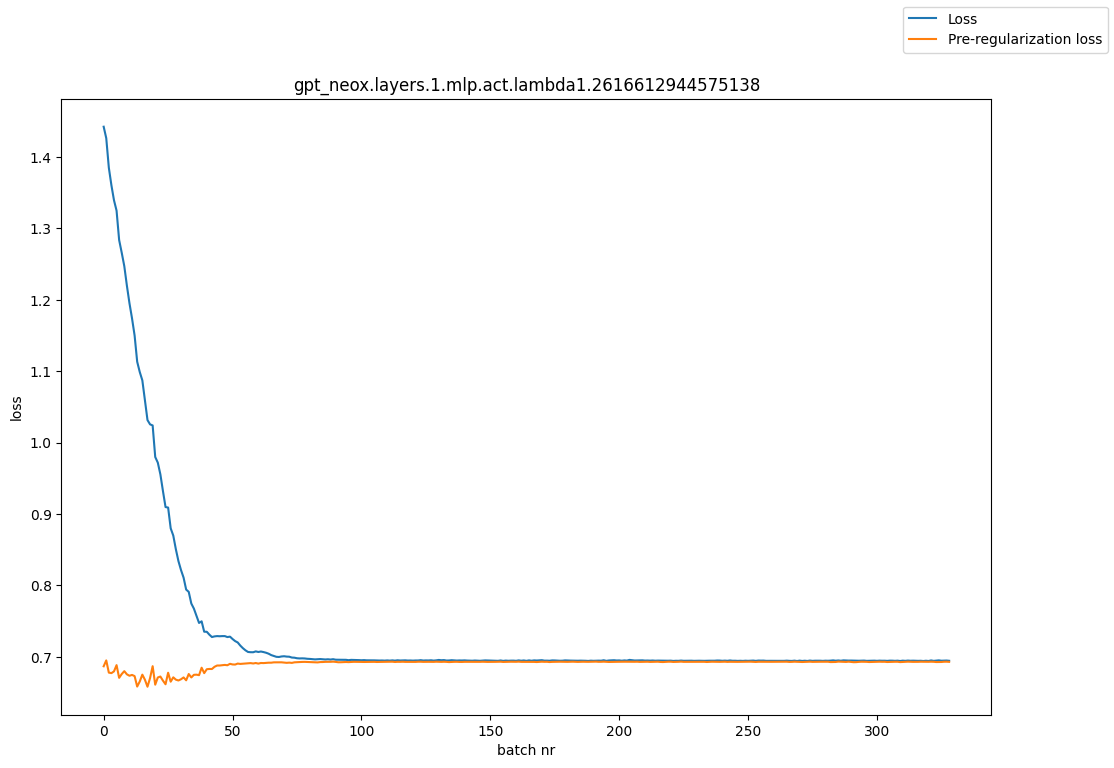

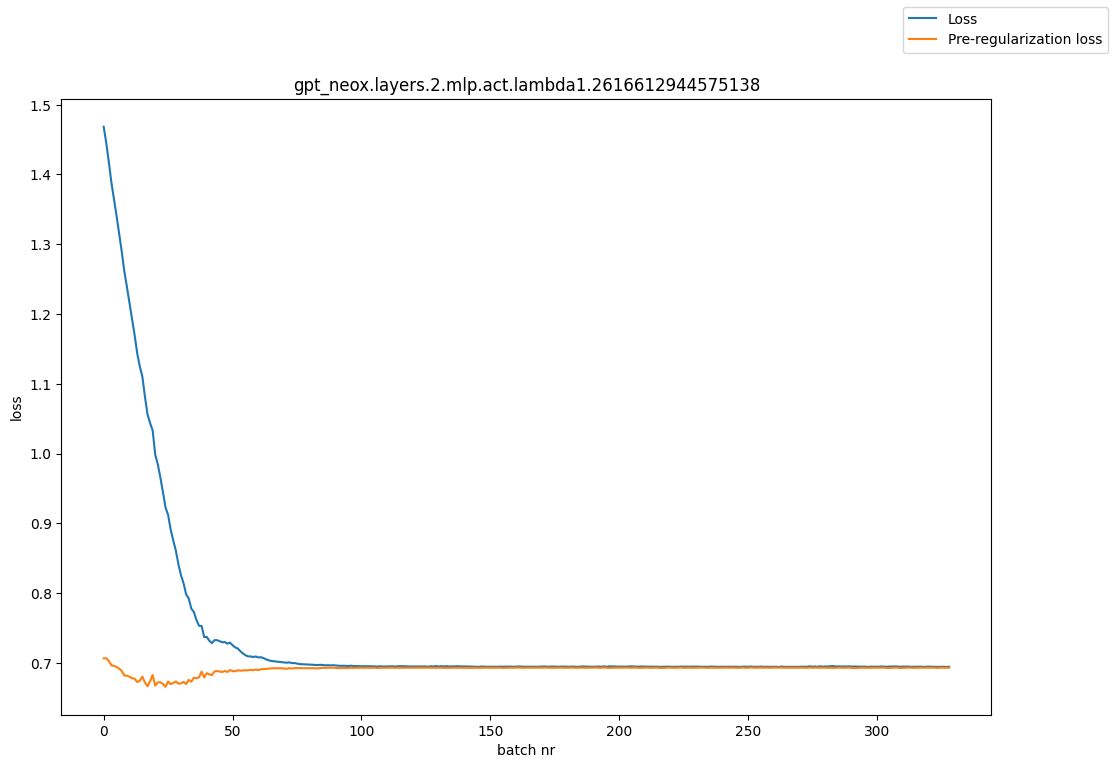

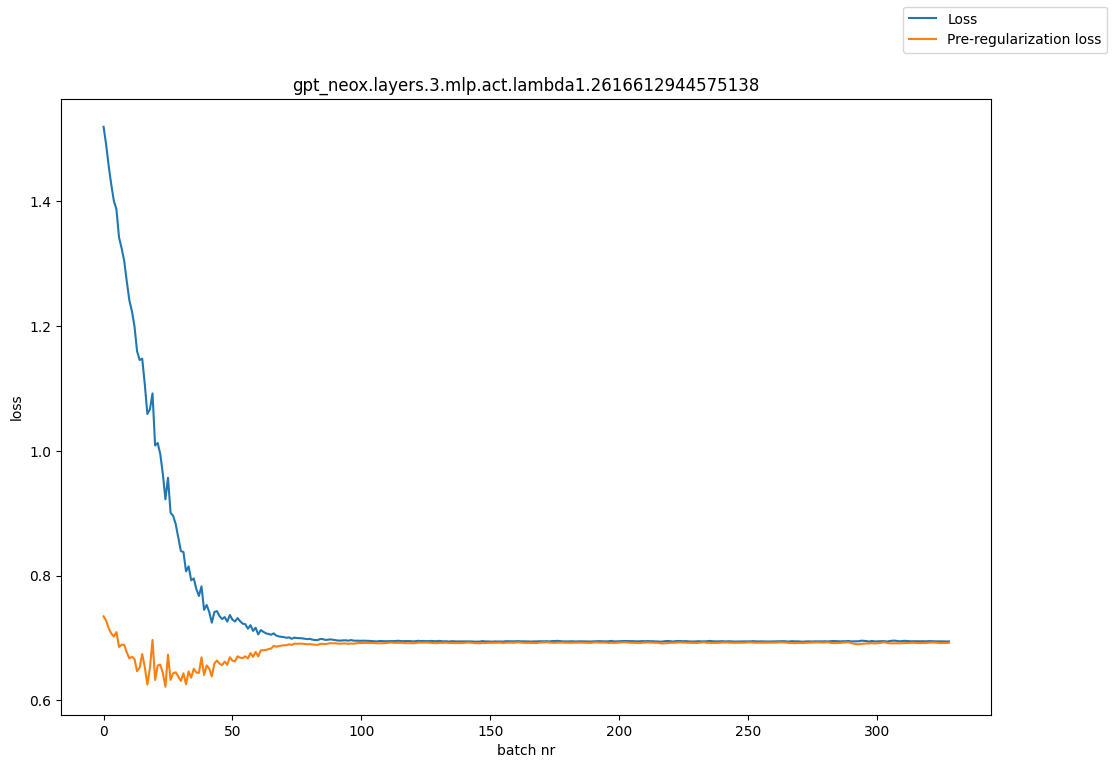

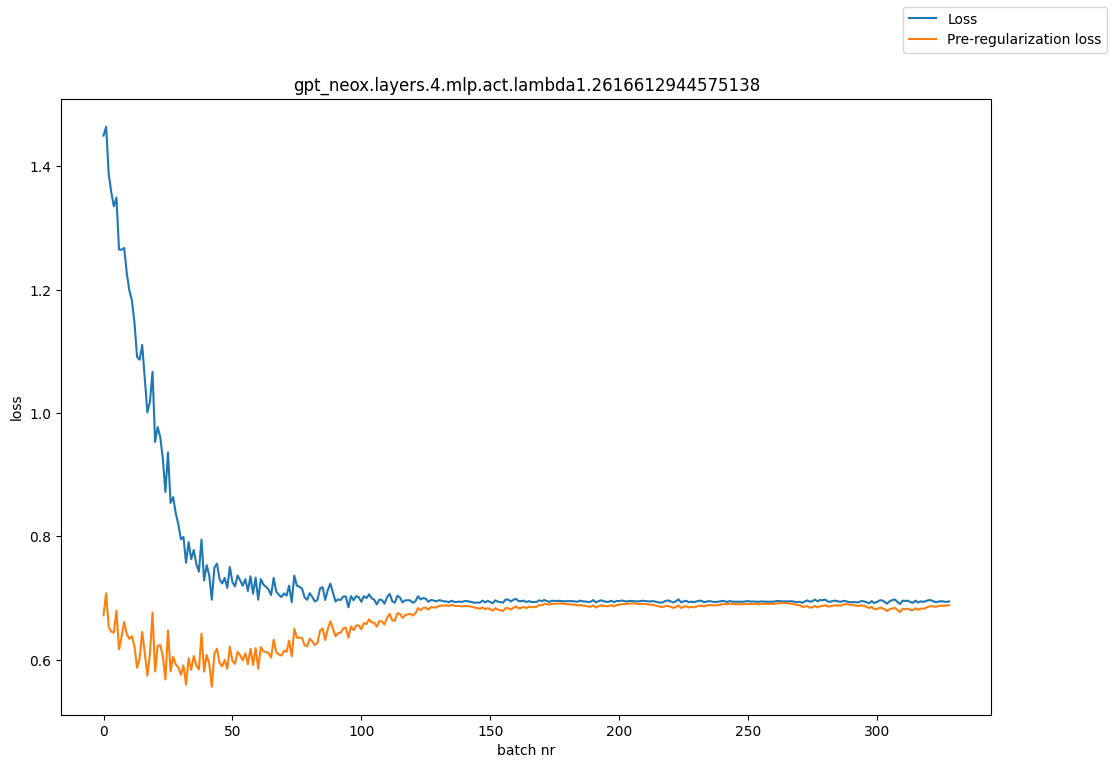

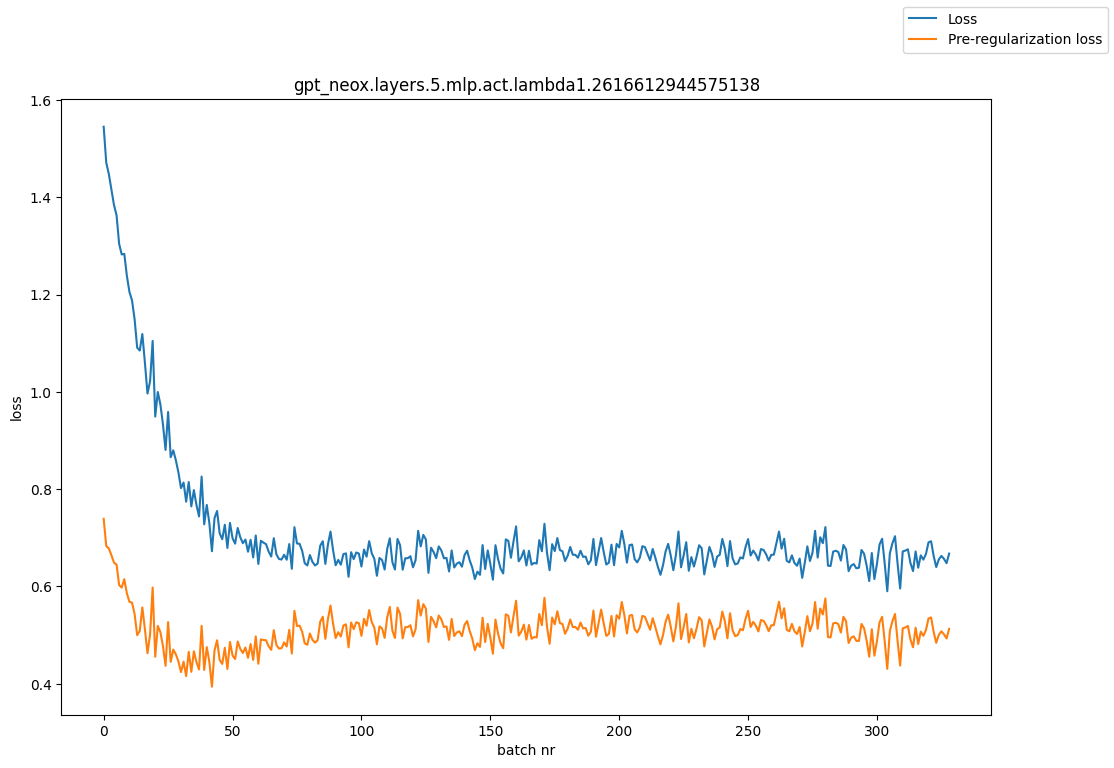

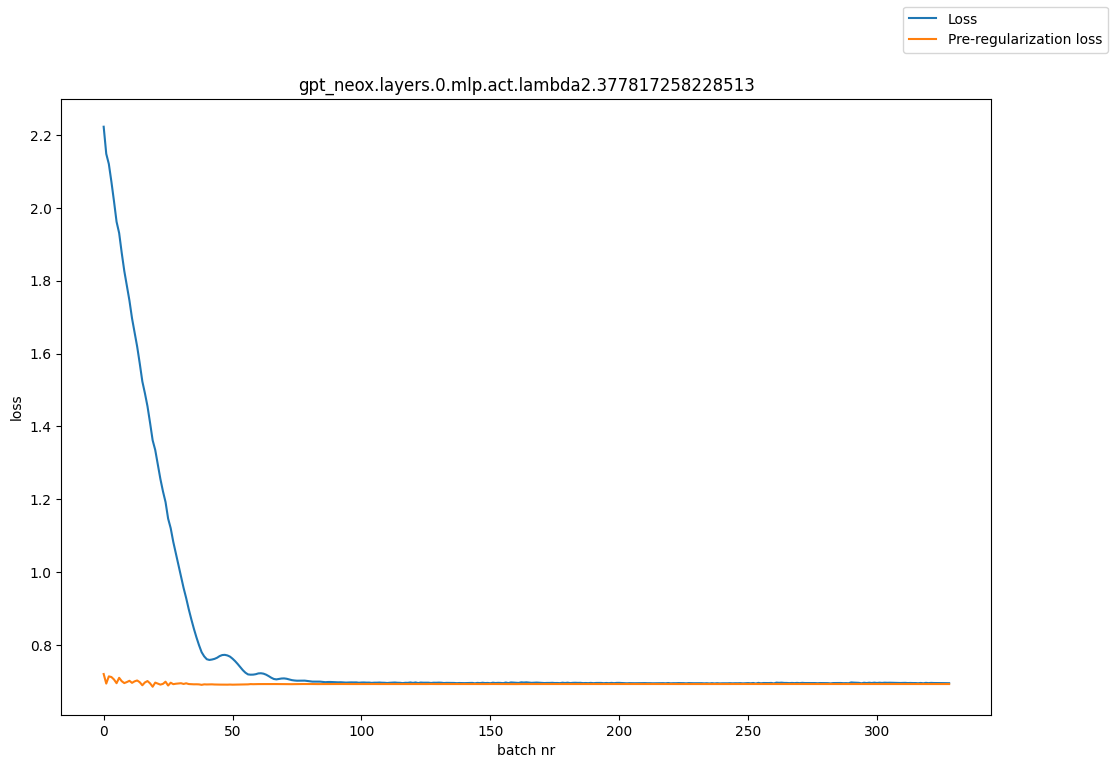

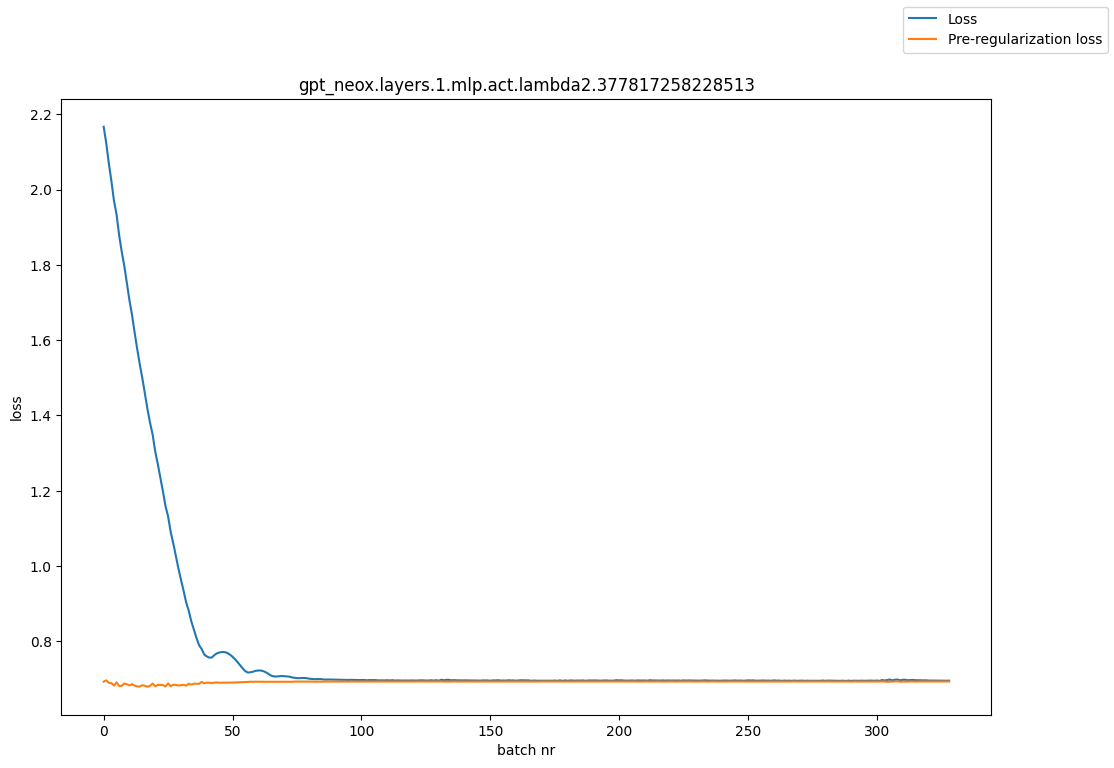

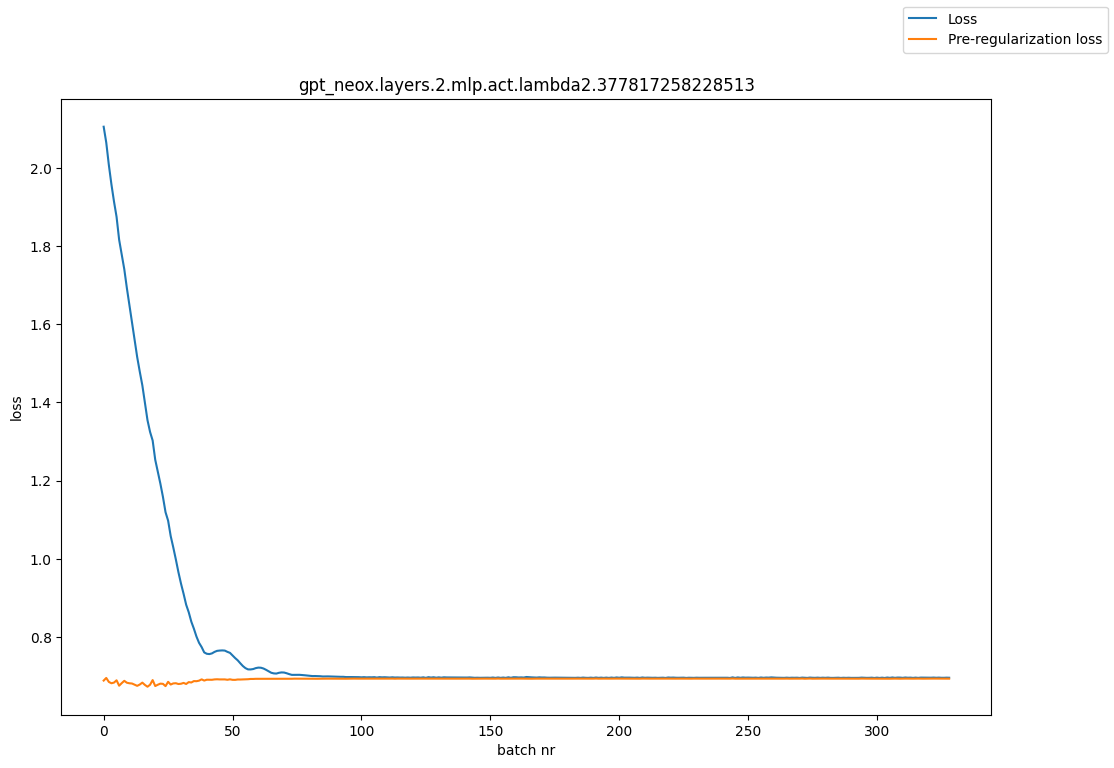

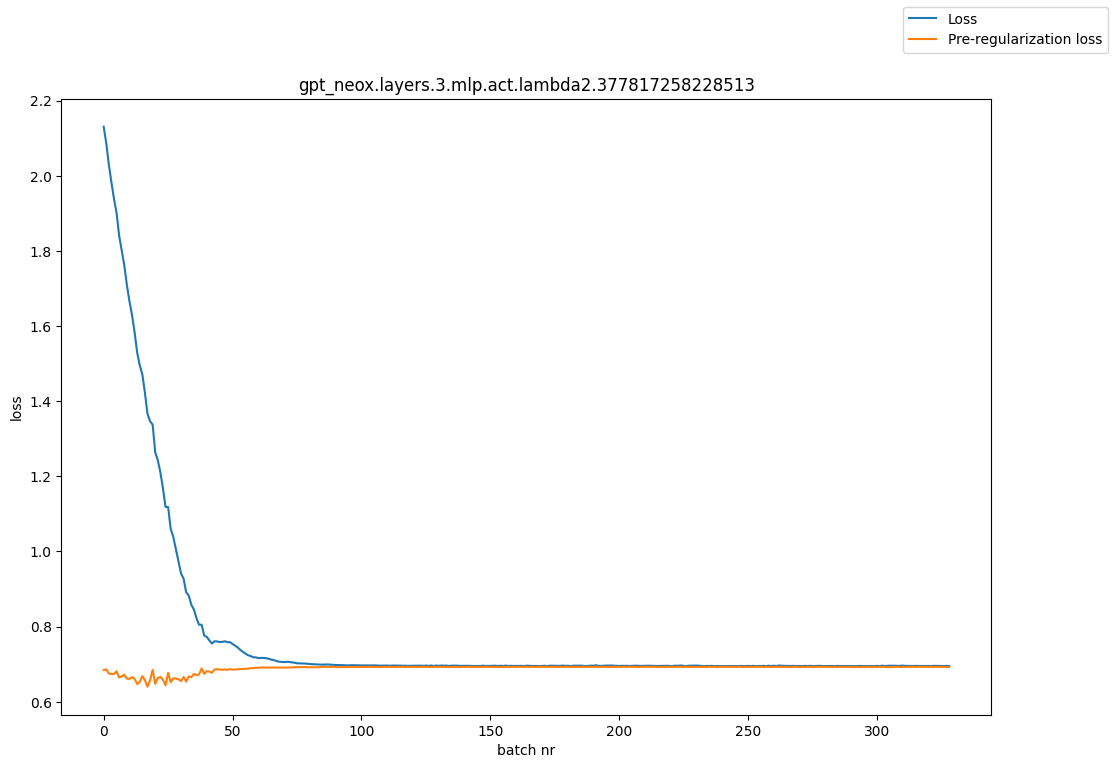

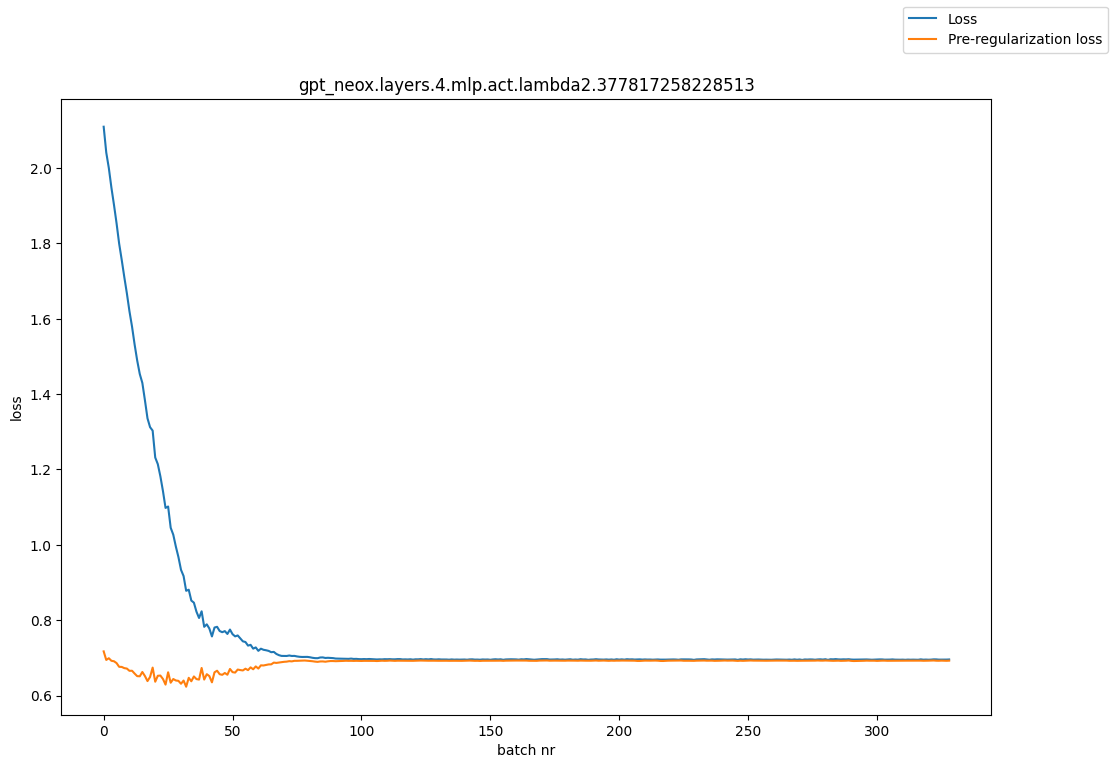

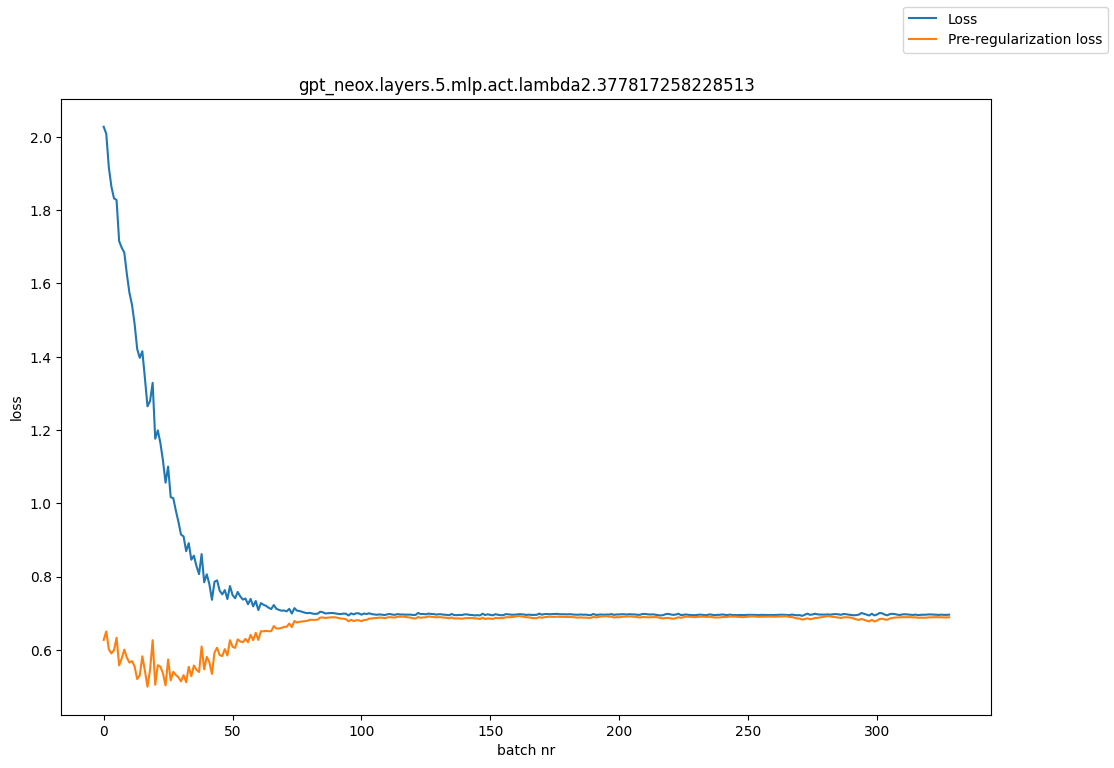

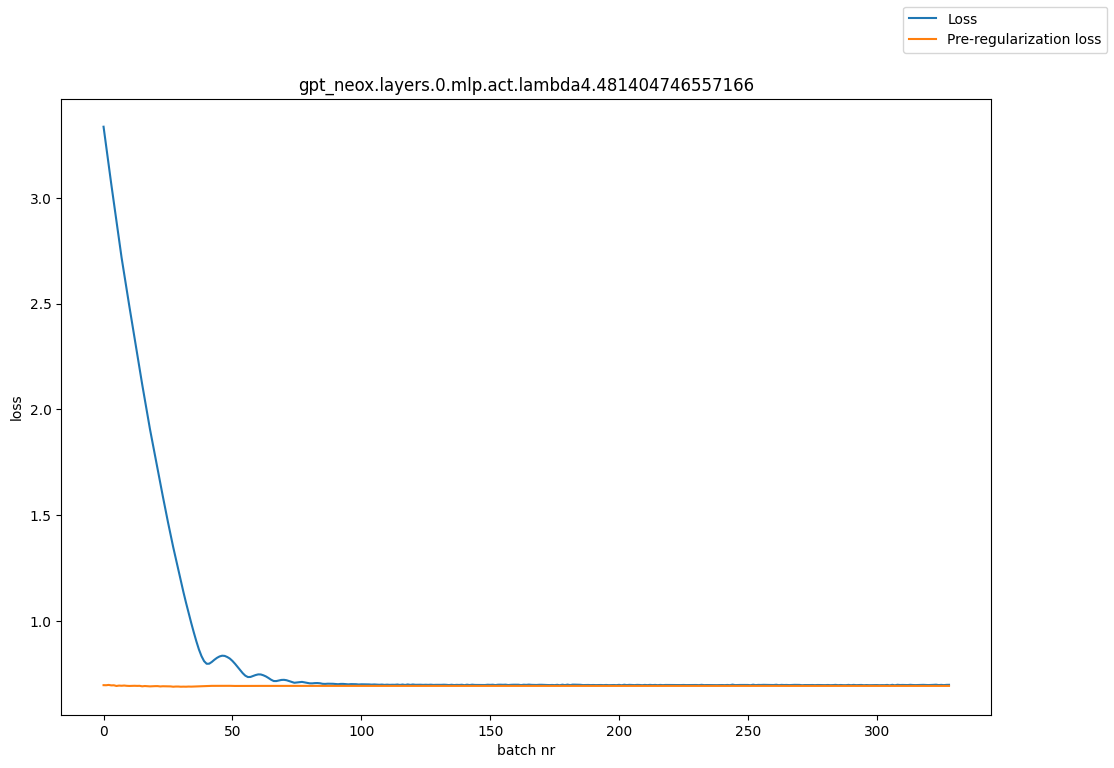

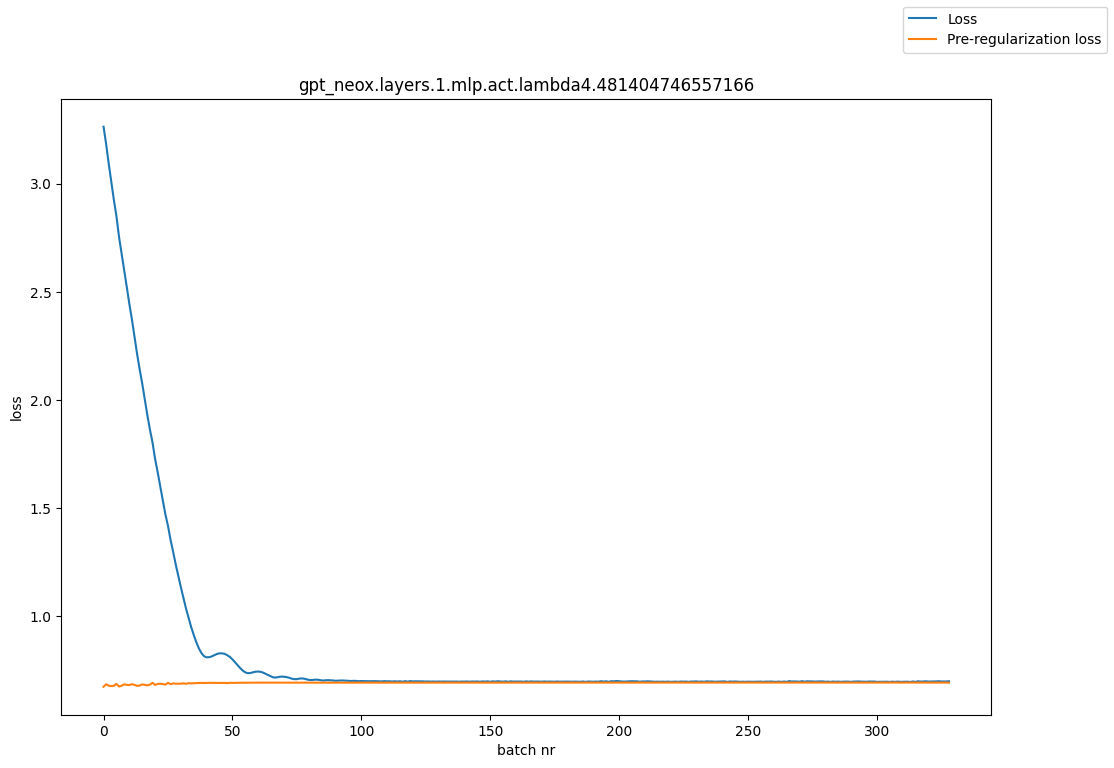

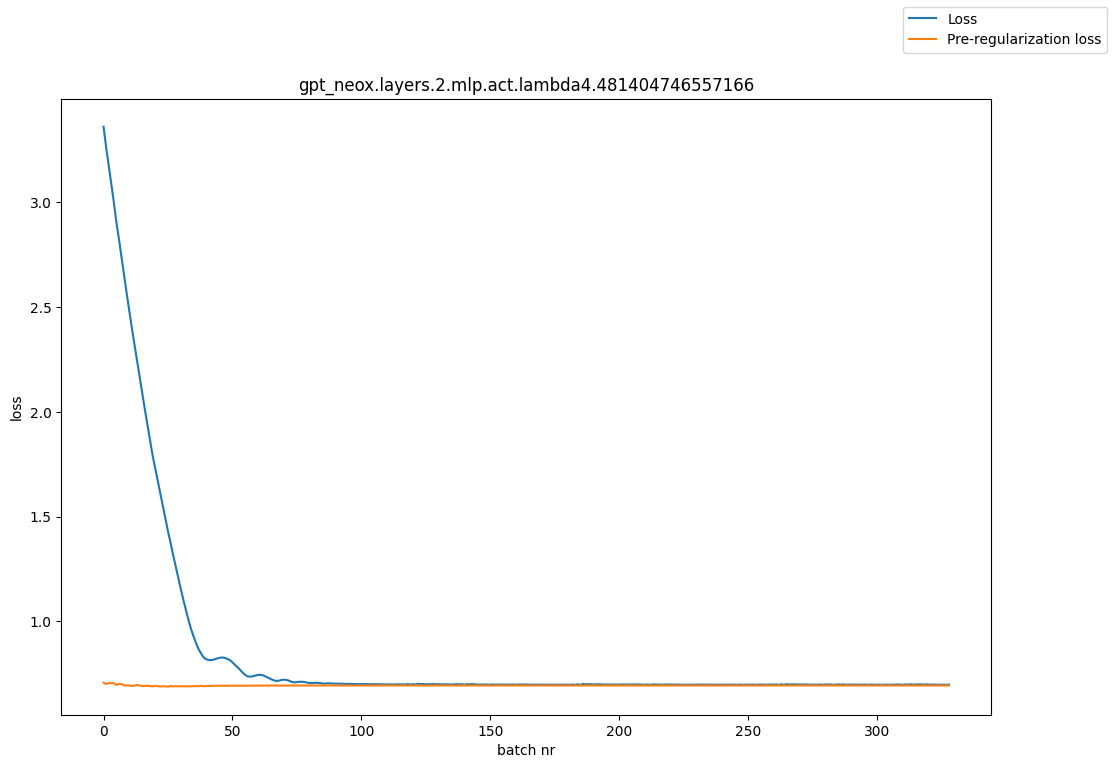

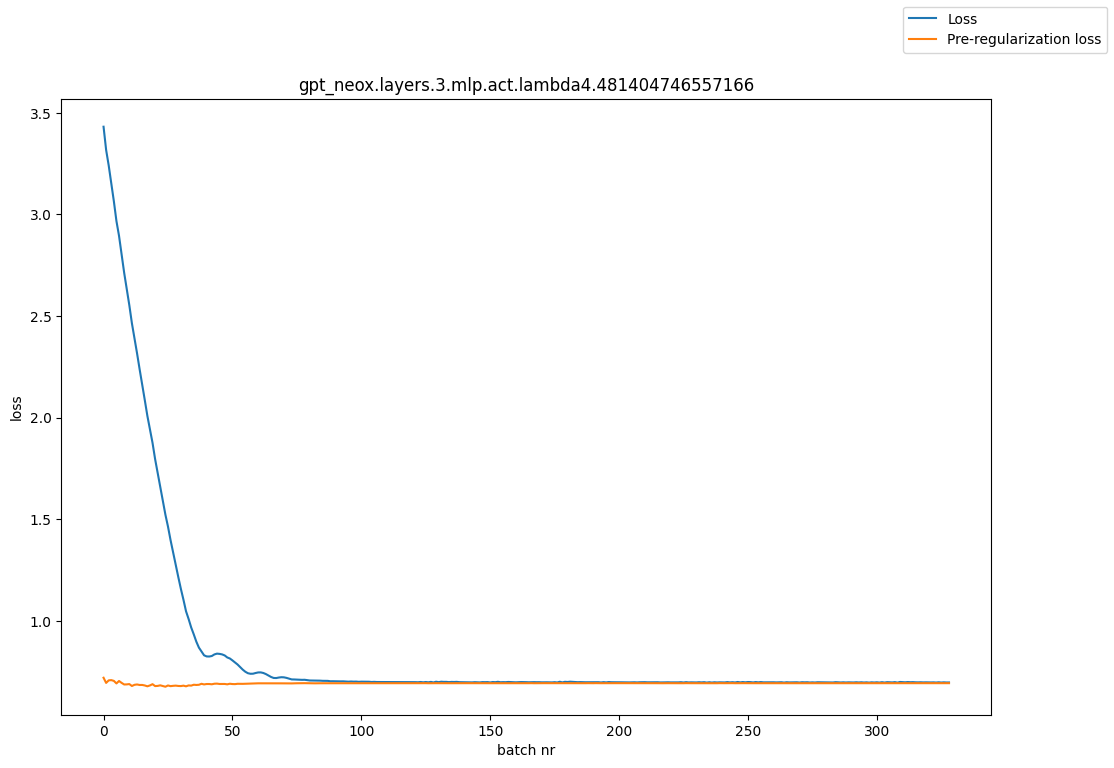

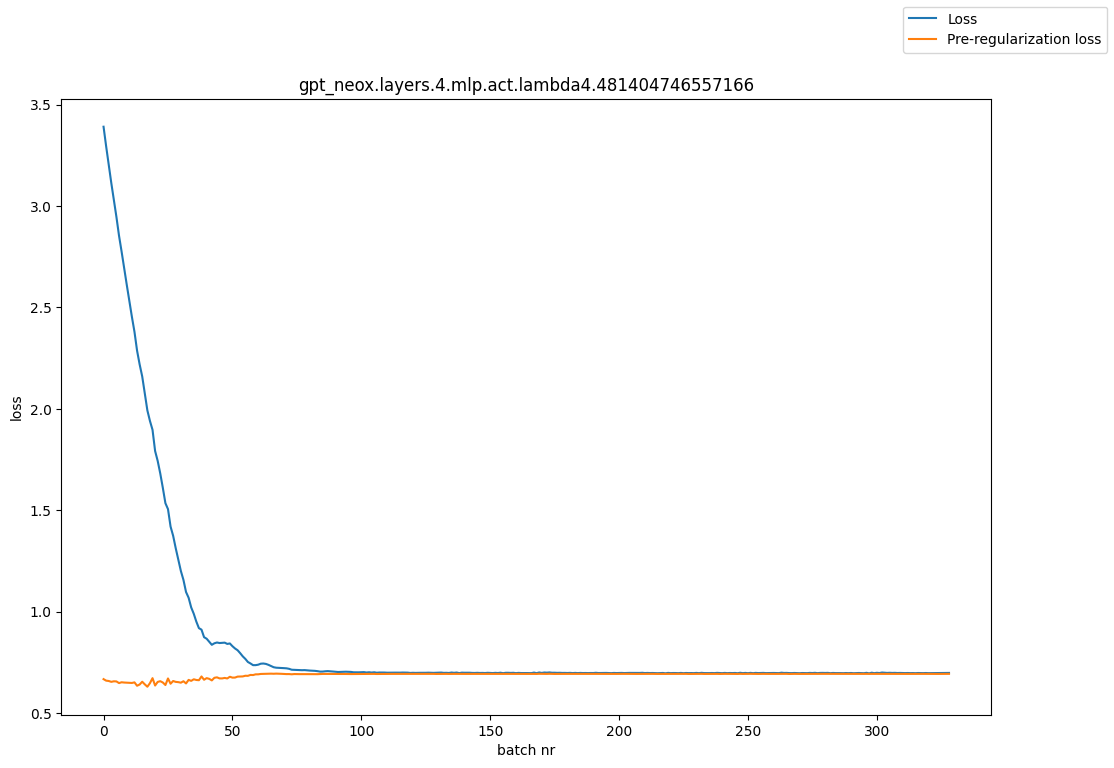

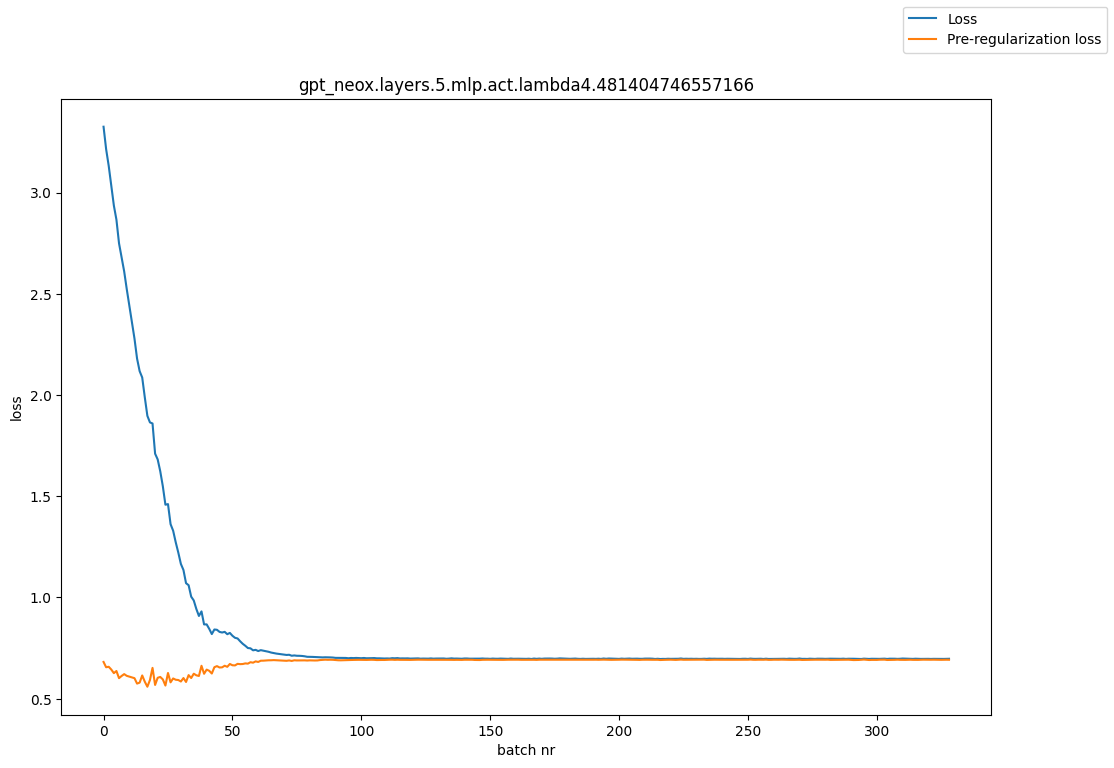

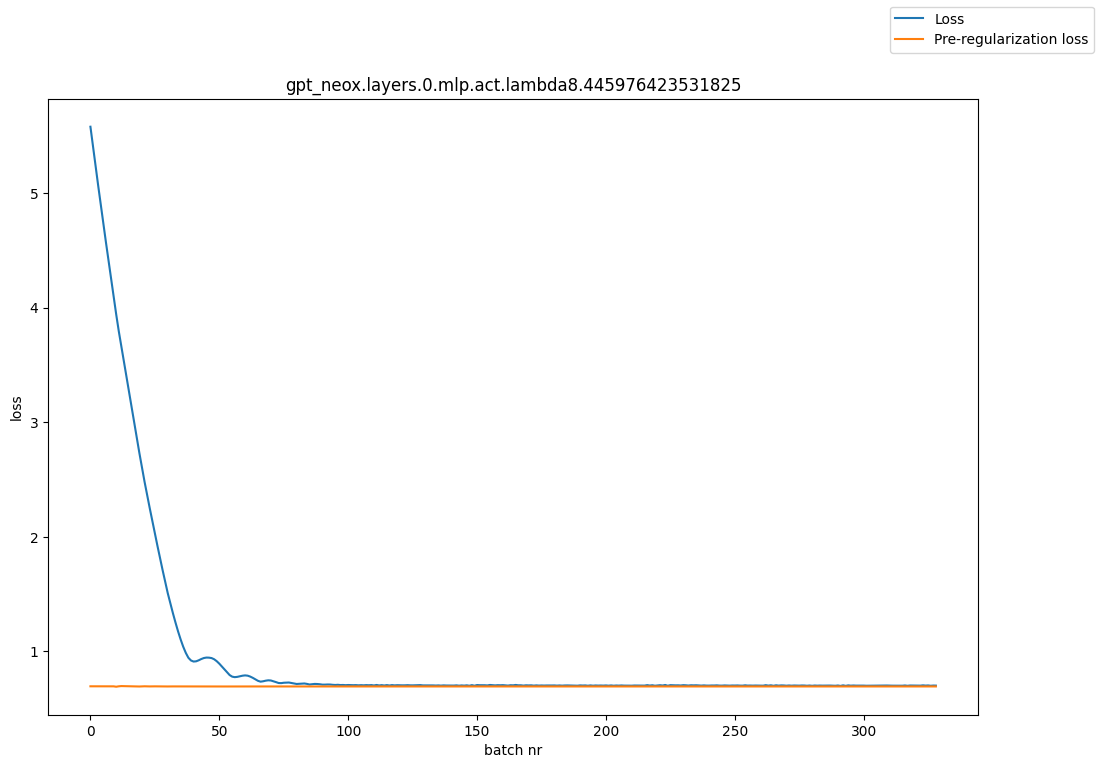

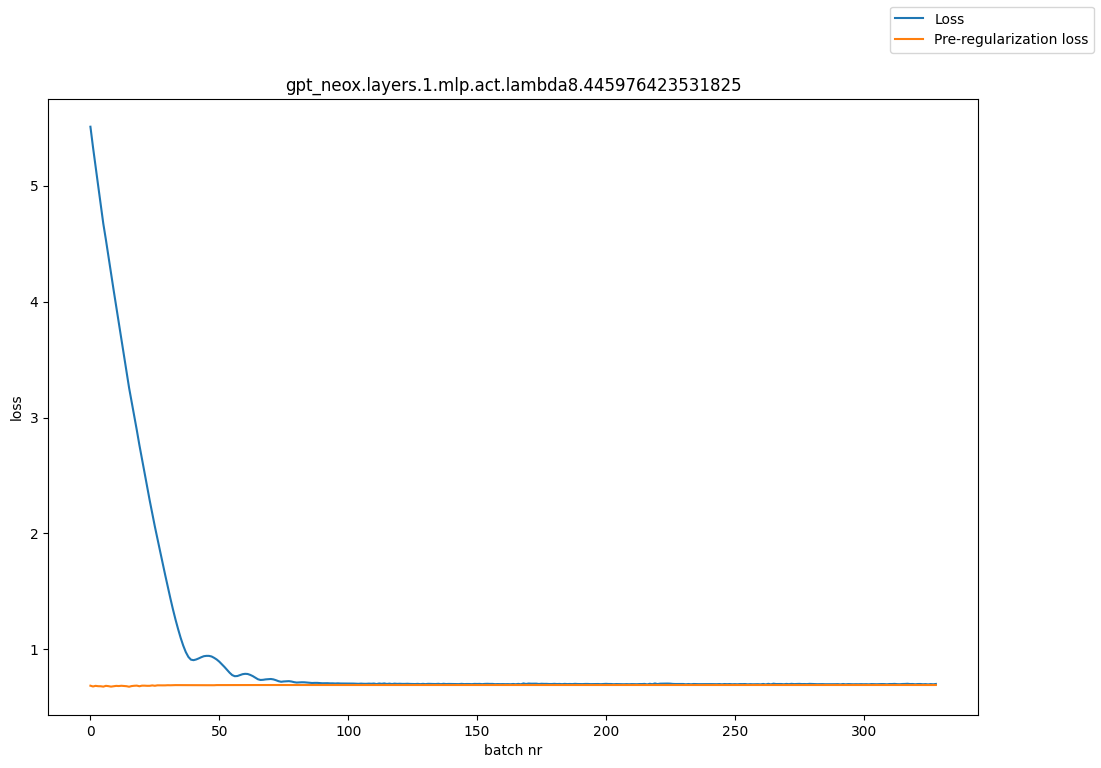

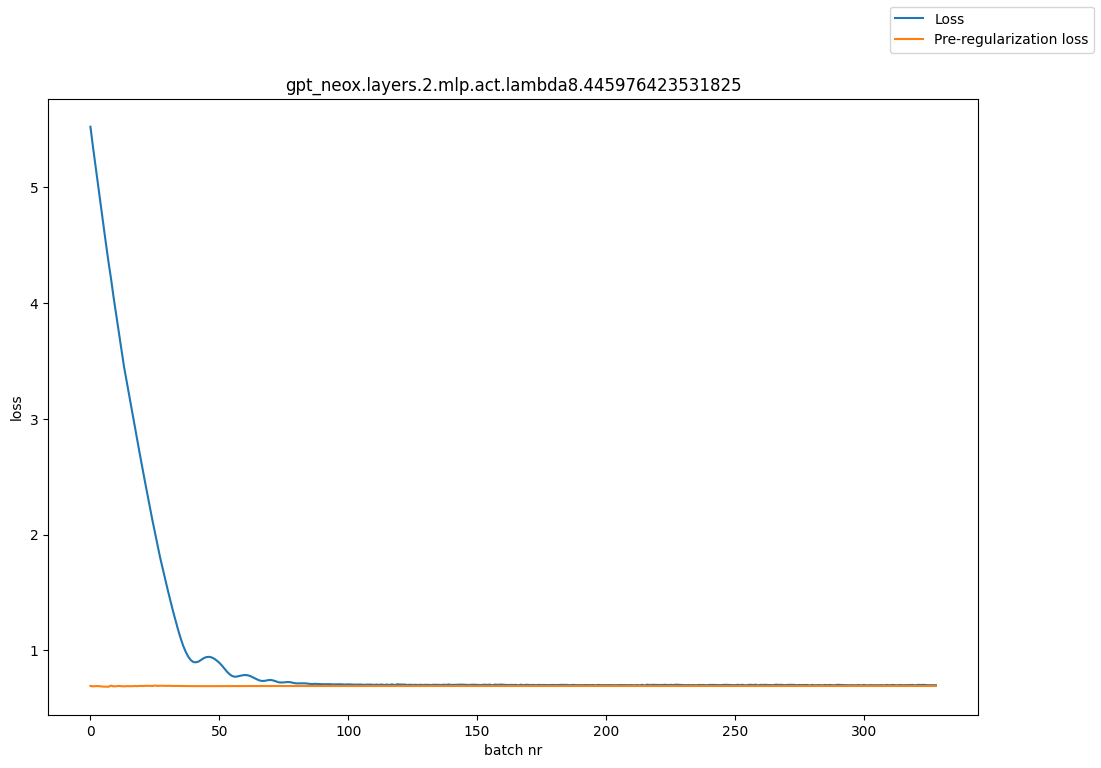

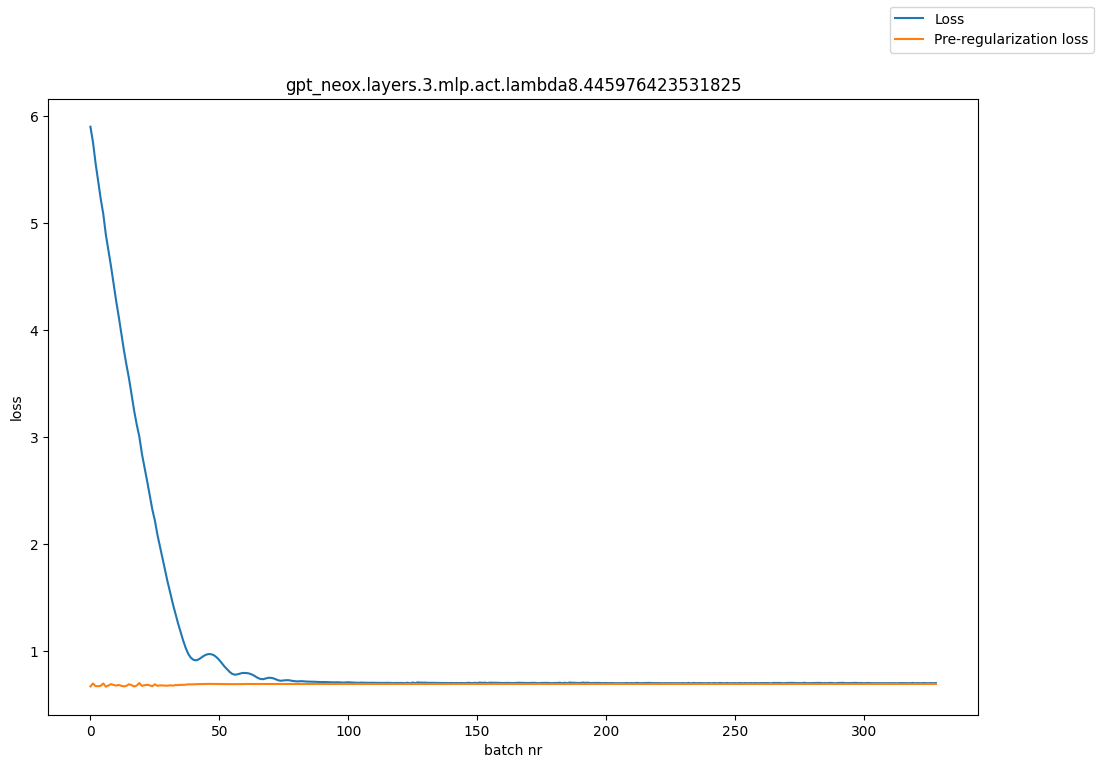

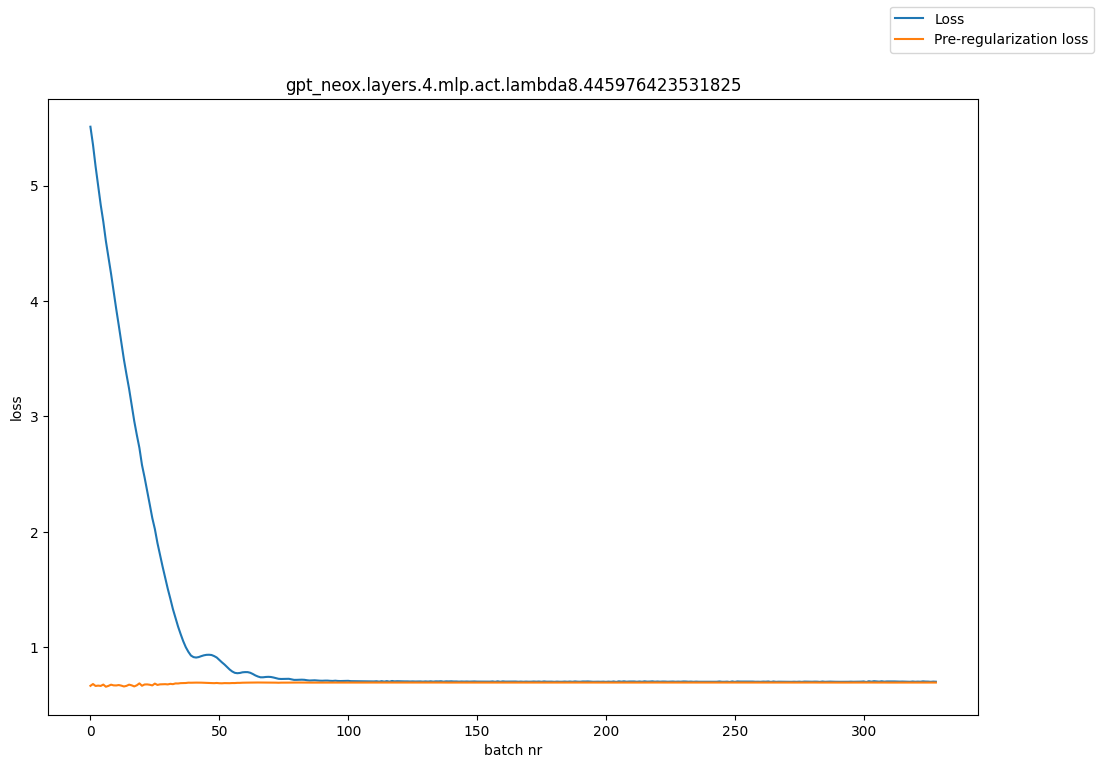

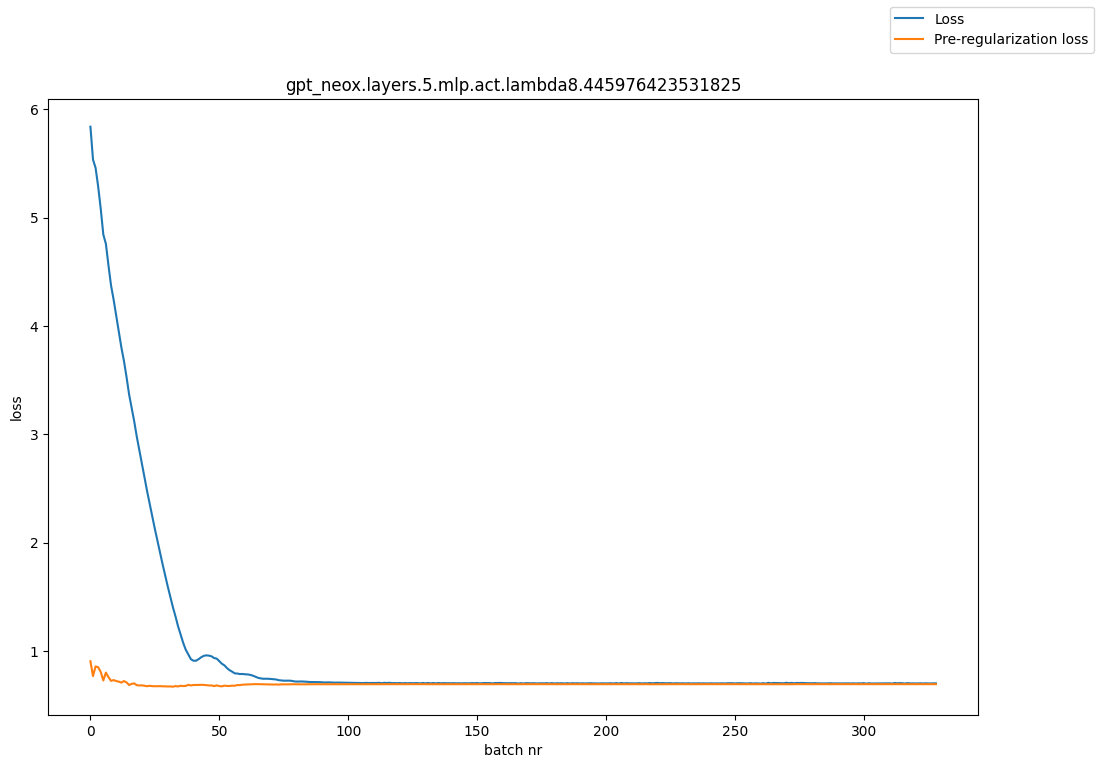

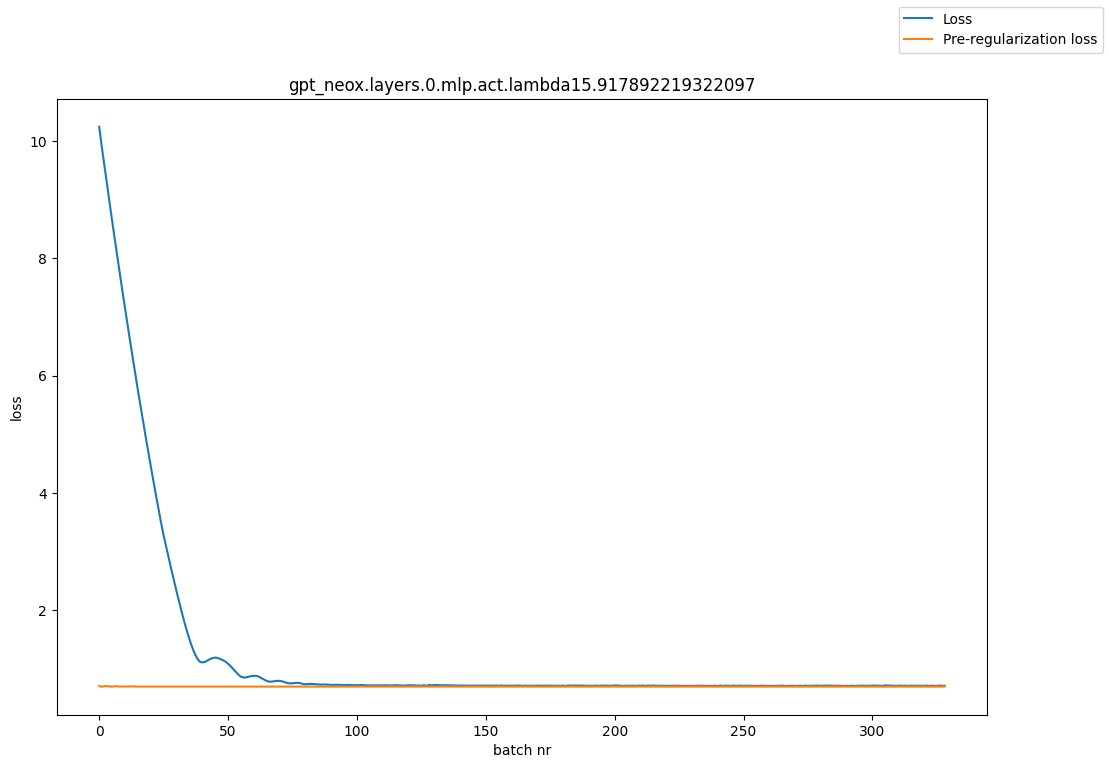

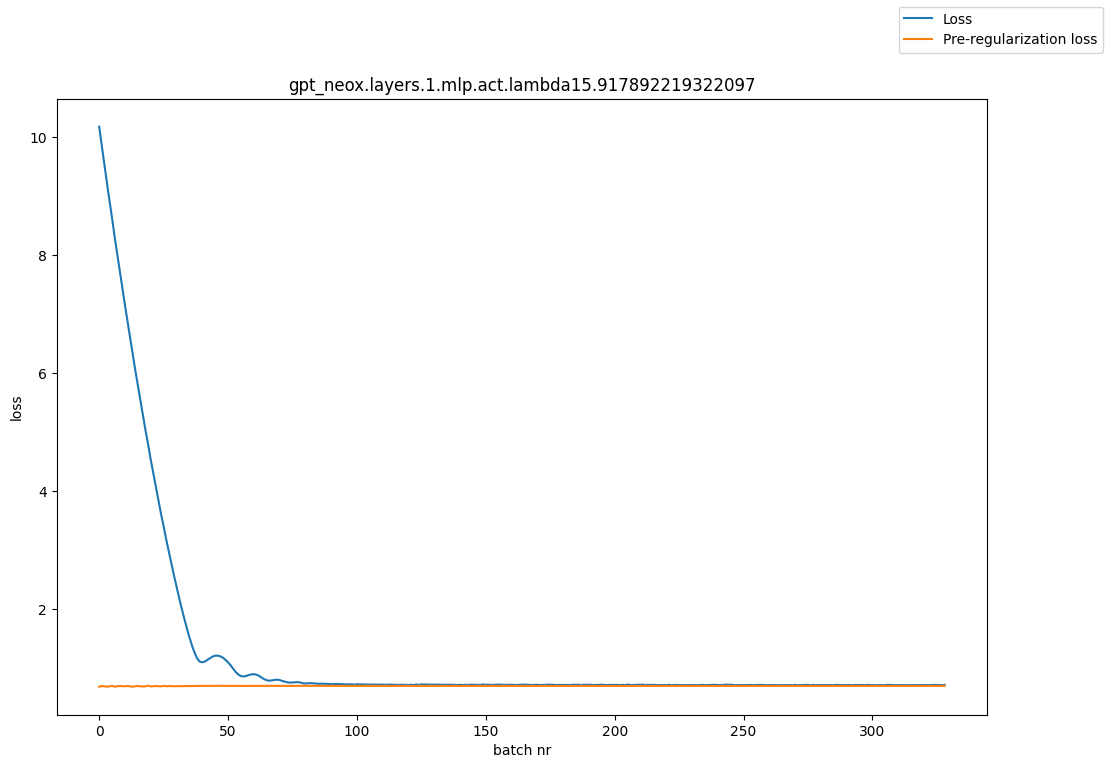

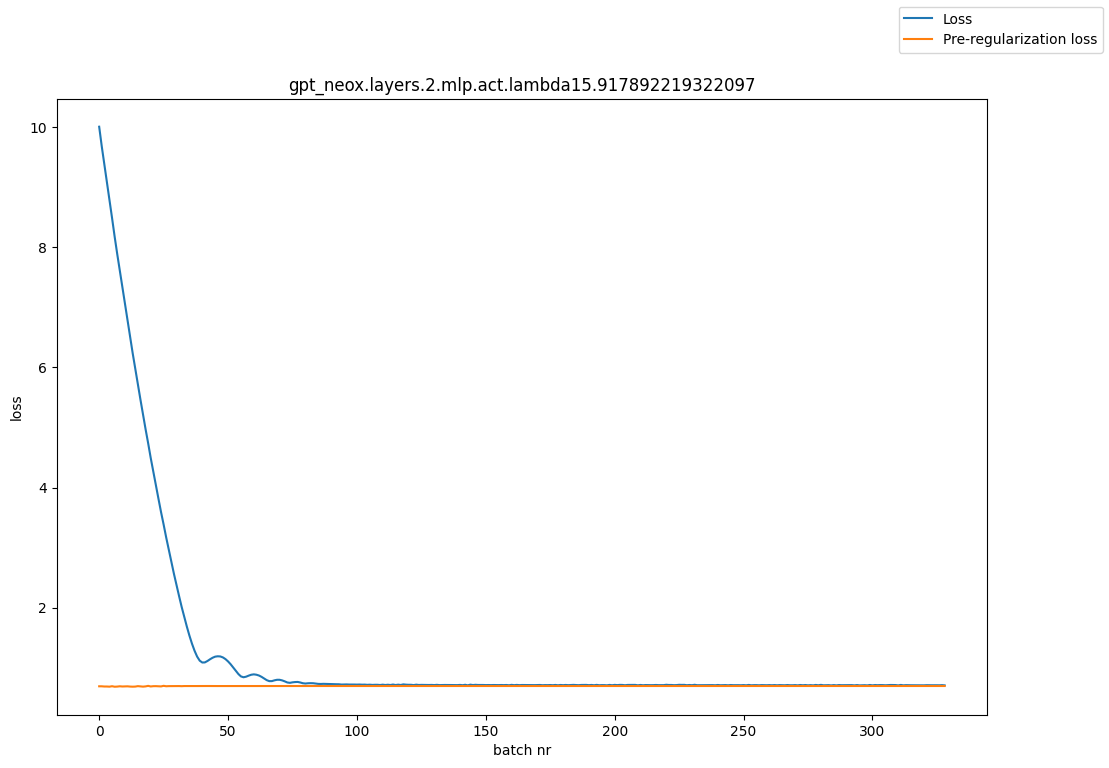

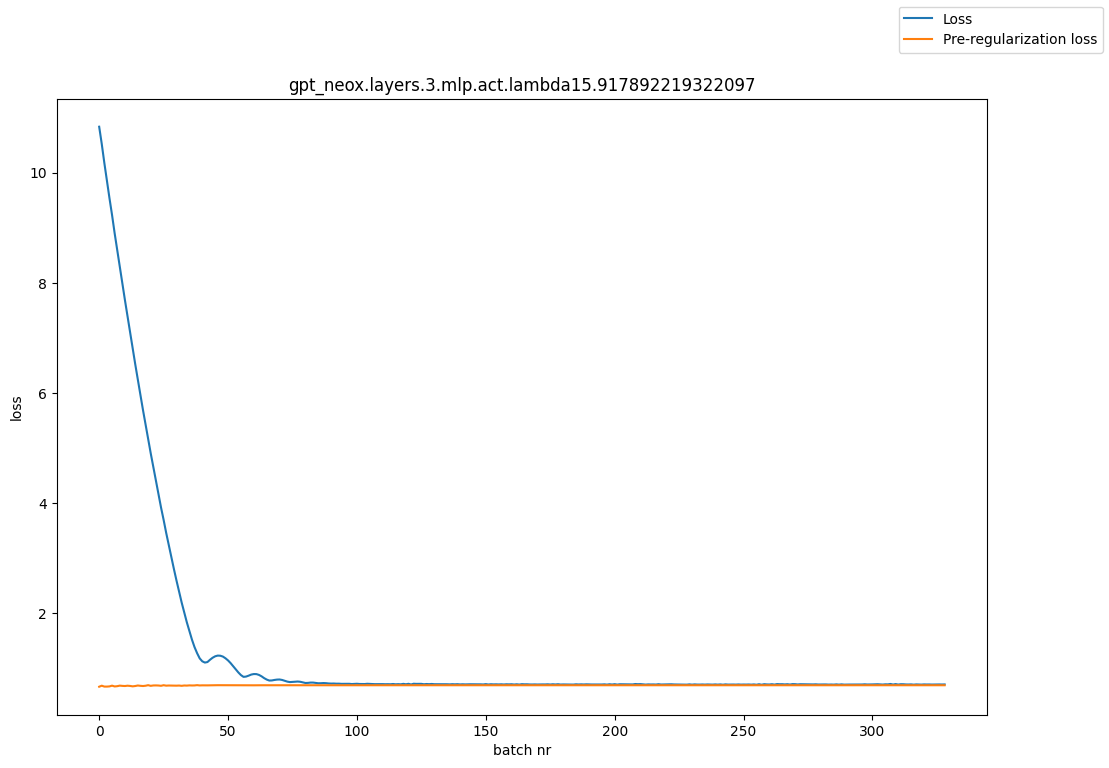

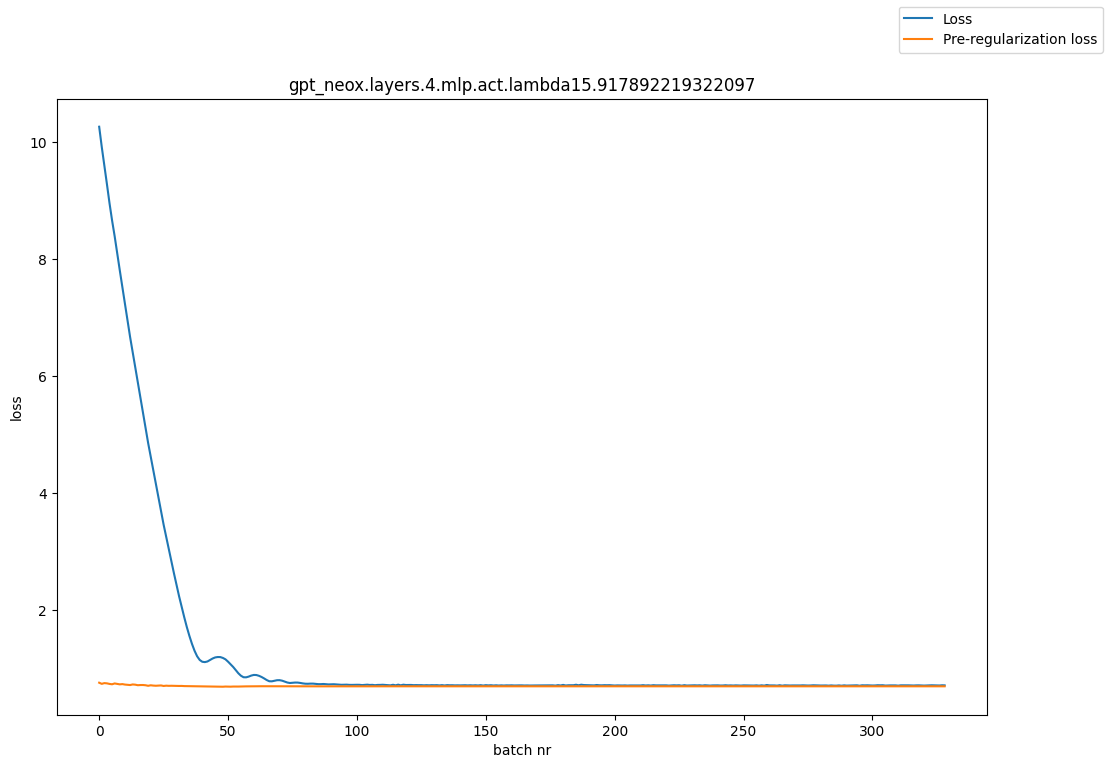

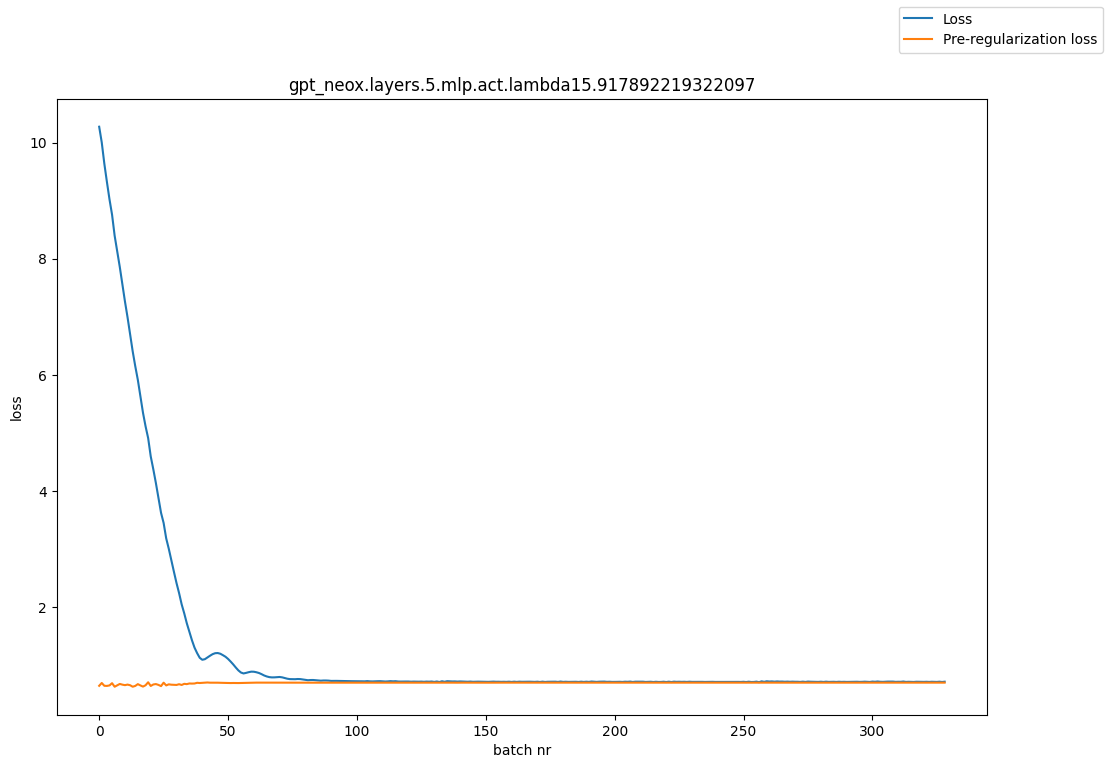

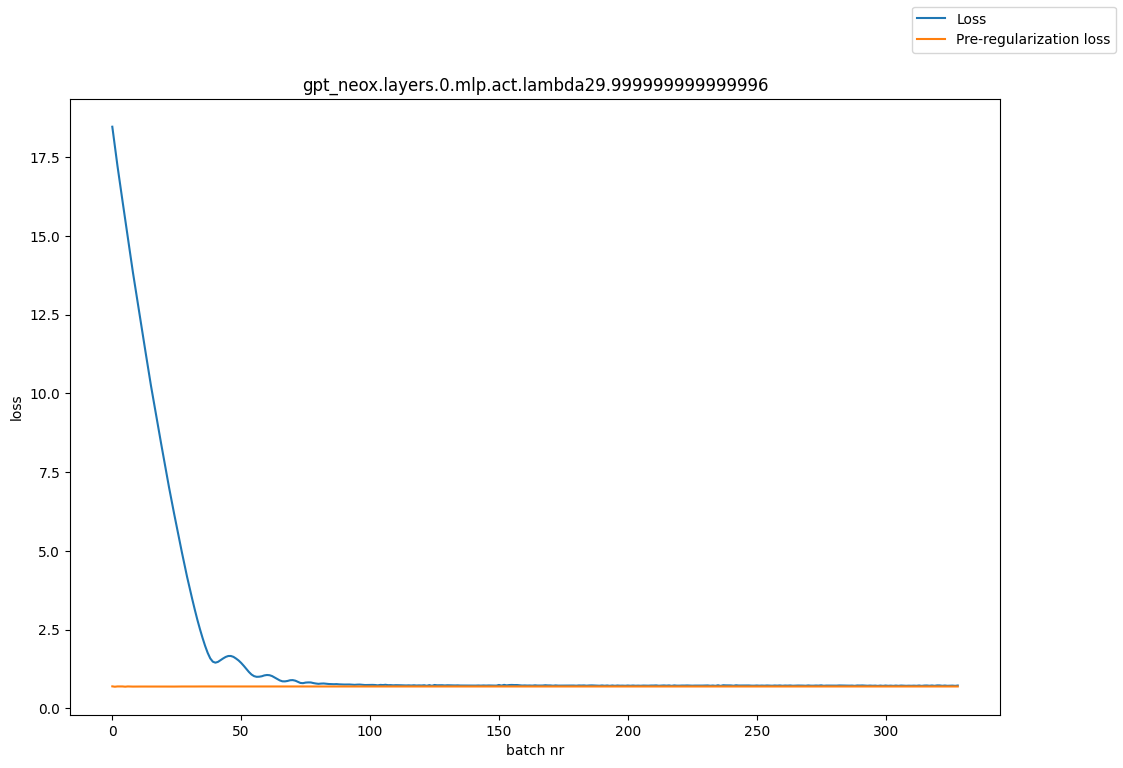

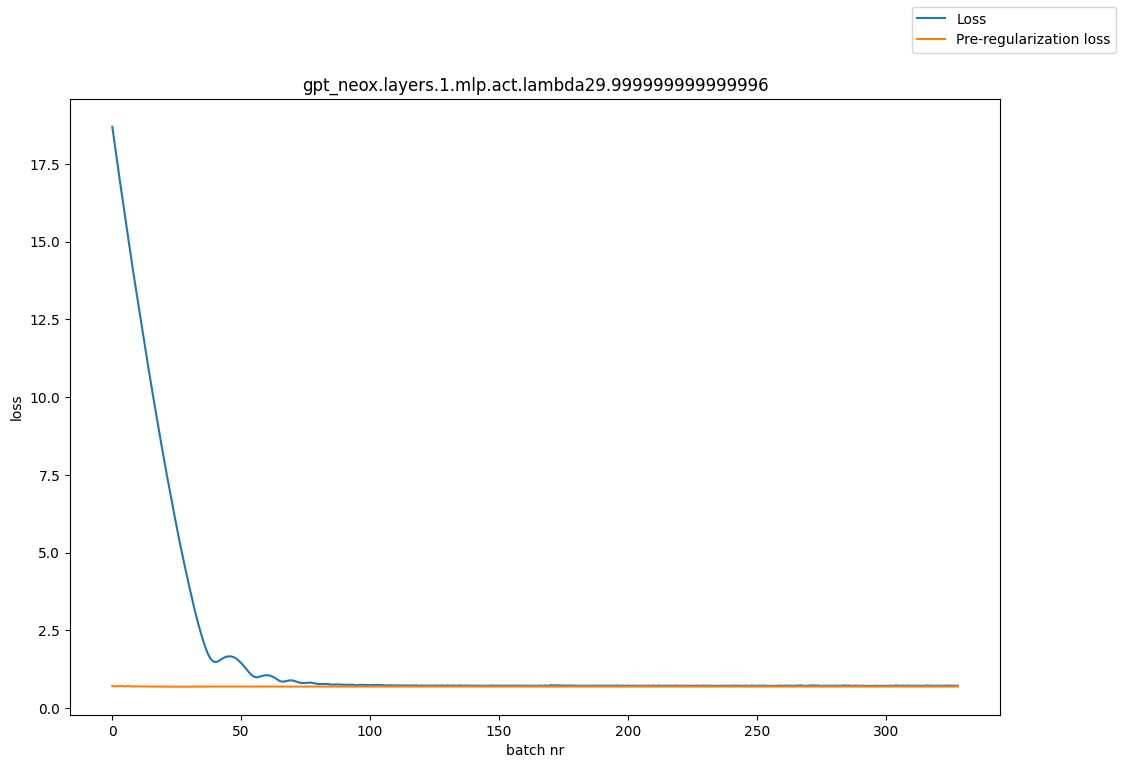

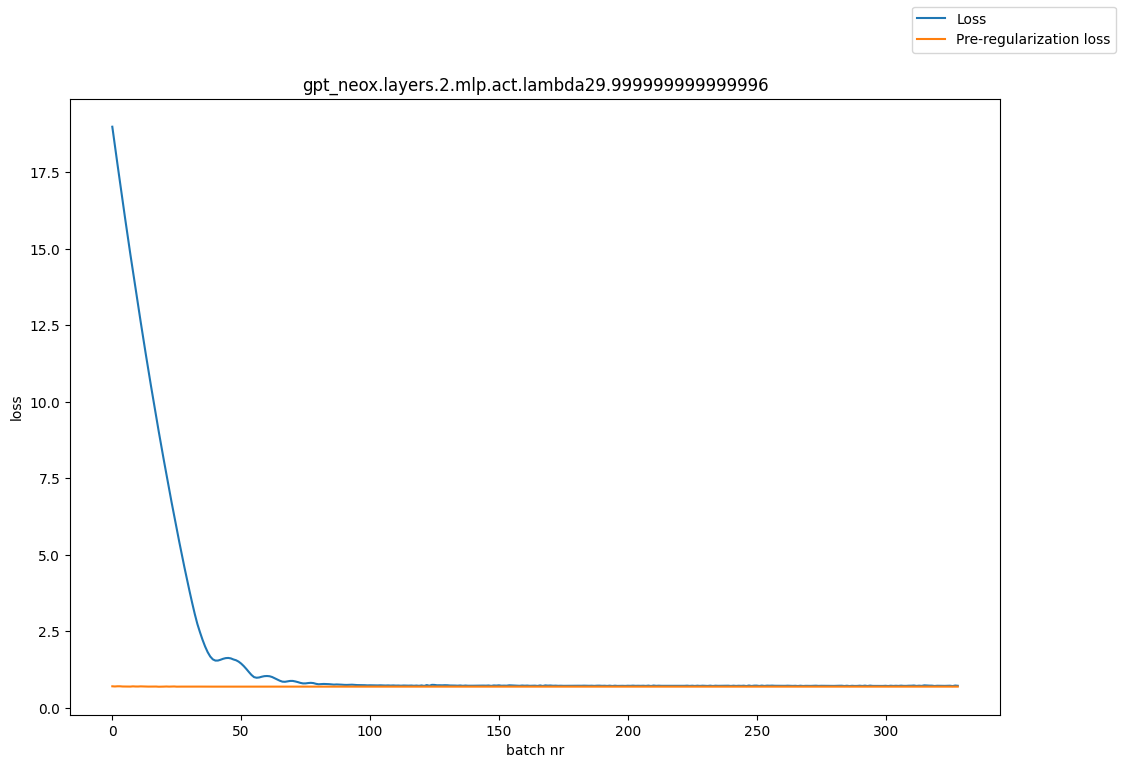

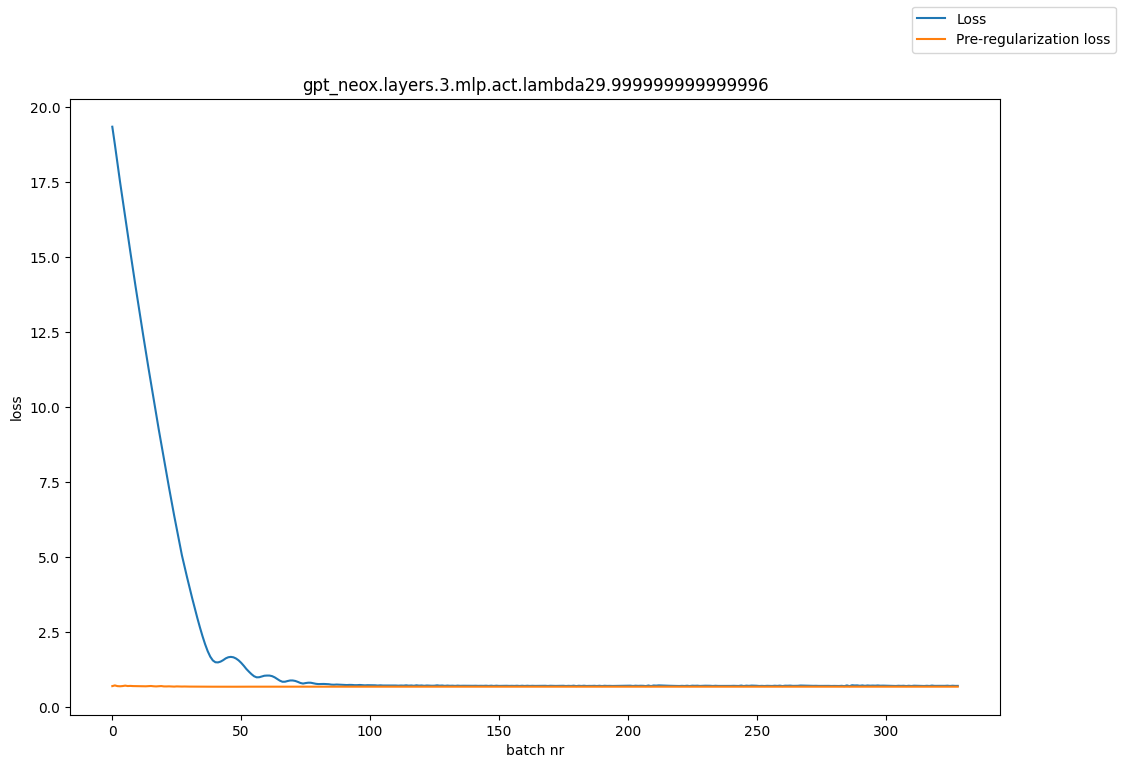

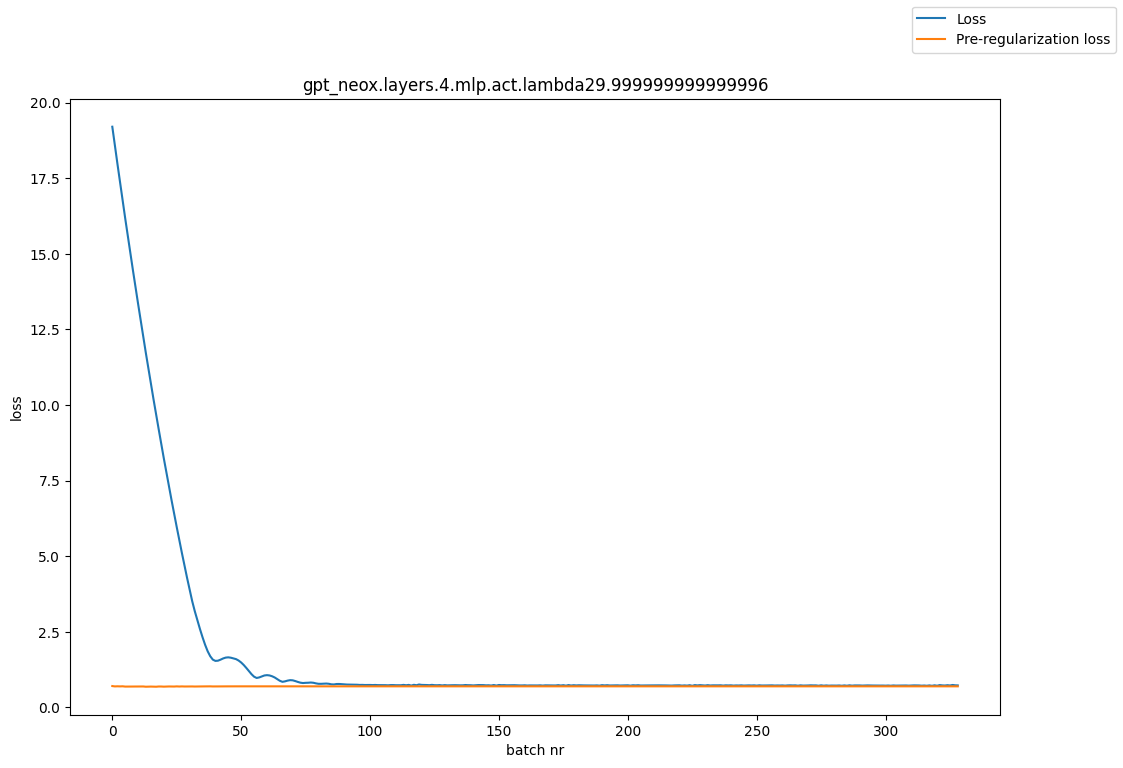

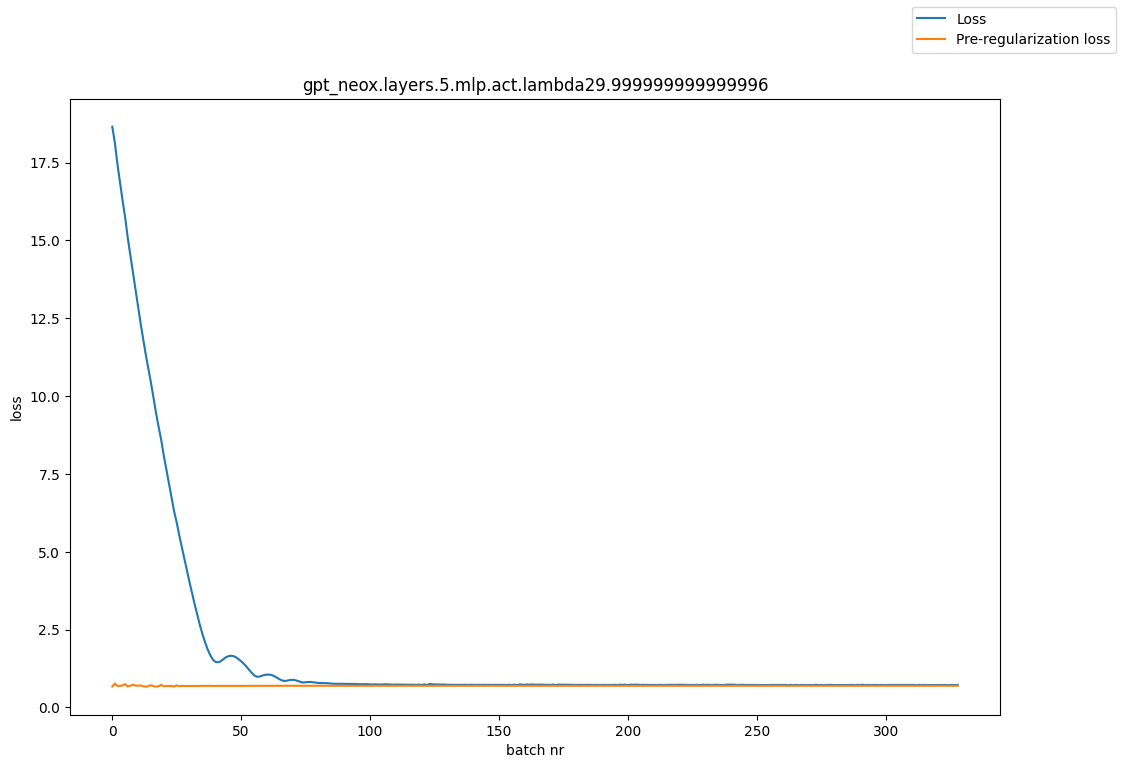

In [5]:
out_folder = f"models/sparse_probes/{model_url.split('/')[-1]}"
log_folder = f"training_logs/sparse_probes/{model_url.split('/')[-1]}"


if not os.path.isdir(out_folder):
    os.mkdir(out_folder)
if not os.path.isdir(log_folder):
    os.mkdir(log_folder)

for probe_trainer in probe_trainers:

    out_folder_reg_lambda = out_folder + f'/reg_lambda{probe_trainer.reg_lambda}'
    log_folder_reg_lambda = log_folder + f'/reg_lambda{probe_trainer.reg_lambda}'

    if not os.path.isdir(out_folder_reg_lambda):
        os.mkdir(out_folder_reg_lambda)
    if not os.path.isdir(log_folder_reg_lambda):
        os.mkdir(log_folder_reg_lambda)
    
    probe = probe_trainer.model
    hookpoint = probe_trainer.hookpoint

    model_out_path = out_folder_reg_lambda + f'/{hookpoint}.pt'
    meta_data_out_path = out_folder_reg_lambda + f'/{hookpoint}.json'
    log_path = log_folder_reg_lambda + f'/{hookpoint}.csv'
    log_fig_path = log_folder_reg_lambda + f'/{hookpoint}.png'

    torch.save(probe.state_dict(), model_out_path)

    meta_data = {
        'batch_size': batch_size,
        'num_batches_trained_on': probe_trainer.batches,
        'learning_rate': probe_trainer.learning_rate,
        'input_size': probe_trainer.input_size,
        'reg_lambda': probe_trainer.reg_lambda,
        'hookpoint': probe_trainer.hookpoint
    }

    with open(meta_data_out_path, 'w') as file:
        json.dump(meta_data, file, indent=4)

    losses, pre_reg_losses = zip(*probe_trainer.losses) 
    df = pd.DataFrame({'loss': losses, 'pre_reg_loss': pre_reg_losses})
    df.to_csv(log_path)

    probe_trainer.plot_loss(out_file=log_fig_path)

In [ ]:
!git add {out_folder}/*
!git add {log_folder}/* 

!git commit -m "testing commits of training output -- not final data"

In [ ]:
!git push